In [1]:
import numpy as np
import time

def estimate_pi(n_points):
    count = 0
    for _ in range(n_points):
        x, y = np.random.random(), np.random.random()
        if x*x + y*y <= 1.0:
            count += 1
    return 4 * count / n_points

# Ejecución
N = 100_000_000
t0 = time.time()
pi_est = estimate_pi(N)
print(f"π ≈ {pi_est:.6f} (Python puro en {time.time() - t0:.3f} s)")


π ≈ 3.141470 (Python puro en 144.300 s)


In [2]:
from numba import njit

@njit
def estimate_pi_numba(n_points):
    count = 0
    for _ in range(n_points):
        x, y = np.random.random(), np.random.random()
        if x*x + y*y <= 1.0:
            count += 1
    return 4 * count / n_points

# primera ejecución (compila)
t0 = time.time()
pi_est = estimate_pi_numba(N)
print(f"π ≈ {pi_est:.6f} (primera vez en {time.time() - t0:.3f} s)")

# segunda ejecución (ya compilada)
t0 = time.time()
pi_est = estimate_pi_numba(N)
print(f"π ≈ {pi_est:.6f} (ya compilada en {time.time() - t0:.3f} s)")

t0 = time.time()
pi_est = estimate_pi_numba(N)
print(f"π ≈ {pi_est:.6f} (ya compilada en {time.time() - t0:.3f} s)")


π ≈ 3.141549 (primera vez en 2.664 s)
π ≈ 3.141356 (ya compilada en 1.426 s)
π ≈ 3.141567 (ya compilada en 1.443 s)


In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
from scipy.special import expit
import plotly.express as px
import pandas as pd
from tqdm import tqdm
np.random.seed(42)
import numba
from numba import njit

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=UserWarning, message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", category=RuntimeWarning)
#############################################################################
#############################################################################
#############################################################################

# Sampling from von Mises Fisher distribution

@njit
def _random_VMF_cos_numba(d, kappa, n):
    """
    Numba-compatible sampler for cos(theta) from the marginal
    density of the von Mises–Fisher distribution.
    Implements the Wood (1994) algorithm.
    """
    out = np.empty(n)

    if kappa == 0.0:
        for i in range(n):
            out[i] = 2.0 * np.random.rand() - 1.0
        return out

    b = (d - 1.0) / (2.0 * kappa + np.sqrt(4.0 * kappa**2 + (d - 1.0)**2))
    x0 = (1.0 - b) / (1.0 + b)
    c = kappa * x0 + (d - 1.0) * np.log(1.0 - x0**2)

    count = 0
    while count < n:
        # batch size: small constant number of trials
        m = min(n - count, 50)
        for _ in range(m):
            # beta(a, b) with a=b=(d-1)/2 using ratio-of-gammas
            a = (d - 1.0) / 2.0
            g1 = np.random.gamma(a, 1.0)
            g2 = np.random.gamma(a, 1.0)
            z = g1 / (g1 + g2)

            t = (1.0 - (1.0 + b) * z) / (1.0 - (1.0 - b) * z)
            u = np.random.rand()
            accept = kappa * t + (d - 1.0) * np.log(1.0 - x0 * t) - c >= np.log(u)
            if accept:
                out[count] = t
                count += 1
                if count >= n:
                    break
    return out


@njit
def random_VMF(mu, kappa, n):
    """
    Von Mises–Fisher sampler on S^{d-1} in R^d (Numba-compatible).

    Parameters:
        mu : (d,) array (mean direction)
        kappa : float >= 0
        n : int (number of samples)
    Returns:
        samples : (n, d) array on the unit sphere
    """
    d = mu.shape[0]
    mu_norm = np.sqrt(np.sum(mu ** 2))
    mu = mu / mu_norm

    # Handle 1D case
    if d == 1:
        samples = np.empty((n, 1))
        for i in range(n):
            p = 1.0 / (1.0 + np.exp(-2.0 * kappa))  # expit(kappa)
            samples[i, 0] = mu[0] * (2.0 * (np.random.rand() < p) - 1.0)
        return samples

    # Sample cos(theta)
    cos_theta = _random_VMF_cos_numba(d, kappa, n)
    sin_theta = np.sqrt(1.0 - cos_theta ** 2)

    samples = np.empty((n, d))
    for i in range(n):
        # random orthogonal vector
        v = np.random.randn(d)
        dot = np.sum(v * mu)
        proj = v - dot * mu
        proj_norm = np.sqrt(np.sum(proj ** 2))
        if proj_norm > 0.0:
            proj /= proj_norm
        samples[i, :] = cos_theta[i] * mu + sin_theta[i] * proj

    return samples


#############################################################################
#############################################################################
#############################################################################

#Trace convergence

def gelman_rubin_rhat(chains):
    m, n = chains.shape
    chain_means = np.mean(chains, axis=1)
    chain_vars = np.var(chains, axis=1, ddof=1)
    
    B = n * np.var(chain_means, ddof=1)
    W = np.mean(chain_vars)
    var_hat = ( (n - 1)/n ) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W)
    return R_hat

def effective_sample_size(chains, max_lag=1000):
    m, n = chains.shape
    mean_chain = np.mean(chains)
    var_chain = np.var(chains, ddof=1)
    autocorr_sum = 0.0
    for lag in range(1, max_lag):
        acov_lag = 0.0
        for chain in chains:
            acov = np.cov(chain[:-lag], chain[lag:])[0, 1]
            acov_lag += acov
        acov_lag /= m
        rho = acov_lag / var_chain
        if rho <= 0: 
            break
        autocorr_sum += 2 * rho
    ess =   1 / (1 + autocorr_sum)
    return ess


def extract_parameter_chains(results_per_chain, Model):
    n_chains = len(results_per_chain)
    n_samples = results_per_chain[0]['samples']['alpha'].shape[0]

    chains = {}
    alpha_chains = np.zeros((n_chains, n_samples))
    for i, result in enumerate(results_per_chain):
        alpha_chains[i, :] = result['samples']['alpha']
    chains['alpha'] = alpha_chains

    Z_samples = results_per_chain[0]['samples']['Z']
    n_nodes = Z_samples.shape[1]
    d = Z_samples.shape[2]

    Z_chains = {}
    for node in range(n_nodes):
        for dim in range(d):
            key = f"Z_{node}_{dim}"
            Z_chains[key] = np.zeros((n_chains, n_samples))
            for i, result in enumerate(results_per_chain):
                Z_chains[key][i, :] = result['samples']['Z'][:, node, dim]
    chains.update(Z_chains)

    if Model == 'Spherical':
        beta_chains = np.zeros((n_chains, n_samples))
        for i, result in enumerate(results_per_chain):
            beta_chains[i, :] = result['samples']['beta']
        chains['beta'] = beta_chains

    return chains

def compute_diagnostics_dataframe(results_per_chain, Model, max_lag=1000):

    chains_dict = extract_parameter_chains(results_per_chain, Model)

    diagnostics = []
    
    for param, chain_array in chains_dict.items():
        R_hat = gelman_rubin_rhat(chain_array)
        ESS = effective_sample_size(chain_array, max_lag=max_lag)
        diagnostics.append({'parameter': param, 'R_hat': round(R_hat,4), 'ESS/n': round(ESS,4)})
    
    df = pd.DataFrame(diagnostics)
    return df

def merge_results(results_per_chain, Model):
    n_chains = len(results_per_chain)
    n_samples = results_per_chain[0]['samples']['alpha'].shape[0]
    
    alpha_all = np.concatenate([res['samples']['alpha'] for res in results_per_chain], axis=0)
    
    Z_shape = results_per_chain[0]['samples']['Z'].shape  # (n_samples, n_nodes, d)
    n_nodes = Z_shape[1]
    d = Z_shape[2]
    Z_all = np.concatenate([res['samples']['Z'] for res in results_per_chain], axis=0)

    log_likelihood_all = np.concatenate([res['log_likelihood'] for res in results_per_chain])
    log_prior_all = np.concatenate([res['log_prior'] for res in results_per_chain])
    log_posterior_all = np.concatenate([res['log_posterior'] for res in results_per_chain])
  
    acceptance_alpha_all = np.concatenate([res['acceptance_rate_trace']['alpha'] for res in results_per_chain], axis=0)
    acceptance_Z_all = np.concatenate([res['acceptance_rate_trace']['Z'] for res in results_per_chain], axis=0)

    sigma_q_alpha_all = np.mean([res['final_proposal_std']['alpha'] for res in results_per_chain])
    sigma_q_Z_all = np.mean([res['final_proposal_std']['Z'] for res in results_per_chain])

    if Model == "Euclidean":
        results = {
            'samples': {'Z': Z_all, "alpha": alpha_all},
            'acceptance_rate_trace': {'Z': acceptance_Z_all, "alpha": acceptance_alpha_all},
            'log_likelihood': log_likelihood_all,
            'log_prior': log_prior_all,
            'log_posterior': log_posterior_all,
            'final_proposal_std': {'Z': sigma_q_Z_all, "alpha": sigma_q_alpha_all},
        }
    
    if Model == "Spherical":
        beta_all = np.concatenate([res['samples']['beta'] for res in results_per_chain], axis=0)
        acceptance_beta_all = np.concatenate([res['acceptance_rate_trace']['beta'] for res in results_per_chain], axis=0)
        sigma_q_beta_all = np.mean([res['final_proposal_std']['beta'] for res in results_per_chain])

        results = {
            'samples': {'Z': Z_all, "alpha": alpha_all, "beta": beta_all},
            'acceptance_rate_trace': {'Z': acceptance_Z_all, "alpha": acceptance_alpha_all, "beta": acceptance_beta_all},
            'log_likelihood': log_likelihood_all,
            'log_prior': log_prior_all,
            'log_posterior': log_posterior_all,
            'final_proposal_std': {'Z': sigma_q_Z_all, "alpha": sigma_q_alpha_all, "beta": sigma_q_beta_all},
        }
    
    return results


#############################################################################
#############################################################################
#############################################################################

import numpy as np
from scipy.special import expit  # sigmoid


def compute_model_criteria(Y, samples_Z, samples_alpha, samples_beta=None):
    """
    Compute WAIC, DIC, and BIC for Latent Space Models 
    (both Euclidean and Spherical versions).

    Parameters:
        Y : (n, n) numpy array
            Observed adjacency matrix.
        samples_Z : (L, n, d) numpy array
            MCMC samples of latent positions.
        samples_alpha : (L,) numpy array
            MCMC samples of the alpha parameter.
        samples_beta : (L,) numpy array, optional
            MCMC samples of the beta parameter (for Spherical model).

    Returns:
        dic, waic, bic : floats
            The Deviance Information Criterion (DIC), 
            the Watanabe-Akaike Information Criterion (WAIC), 
            and the Bayesian Information Criterion (BIC).
    """
    
    L, n, d = samples_Z.shape
    log_lik = np.zeros((L, n, n))
    
    for l in range(L):
        for i in range(n):
            for j in range(n):
                if i != j:
                    if samples_beta is None:  
                        dist = np.linalg.norm(samples_Z[l, i] - samples_Z[l, j])
                        eta = samples_alpha[l] - dist
                    else: 
                        dot = np.dot(samples_Z[l, i], samples_Z[l, j])
                        eta = samples_alpha[l] + samples_beta[l] * dot

                    p_ij = expit(eta)
                    log_lik[l, i, j] = np.log(p_ij + 1e-10) if Y[i, j] == 1 else np.log(1 - p_ij + 1e-10)
                else:
                    log_lik[l, i, j] = 0.0

    ## WAIC
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0) + 1e-10))
    p_waic = np.sum(np.var(log_lik, axis=0))
    waic = -2 * (lppd - p_waic)

    ## DIC
    deviance_samples = -2 * np.sum(log_lik, axis=(1, 2))
    mean_deviance = np.mean(deviance_samples)

    # Evaluate deviance at posterior mean
    Z_mean = np.mean(samples_Z, axis=0)
    alpha_mean = np.mean(samples_alpha)
    beta_mean = np.mean(samples_beta) if samples_beta is not None else None

    log_lik_mean = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                if samples_beta is None:
                    dist = np.linalg.norm(Z_mean[i] - Z_mean[j])
                    eta = alpha_mean - dist
                else:
                    dot = np.dot(Z_mean[i], Z_mean[j])
                    eta = alpha_mean + beta_mean * dot

                p_ij = expit(eta)
                log_lik_mean[i, j] = np.log(p_ij + 1e-10) if Y[i, j] == 1 else np.log(1 - p_ij + 1e-10)
            else:
                log_lik_mean[i, j] = 0.0

    deviance_mean = -2 * np.sum(log_lik_mean)
    p_dic = mean_deviance - deviance_mean
    dic = mean_deviance + p_dic


    log_lik_sum_mean = np.sum(log_lik_mean)
    k = n * d + 1  
    if samples_beta is not None:
        k += 1 
    n_obs = np.sum(Y != np.eye(n))
    bic = -2 * log_lik_sum_mean + k * np.log(n_obs)
    
    return dic, waic, bic

In [4]:
#############################################################################
#############################################################################
#############################################################################

@njit
def log_prior_euclidean(params, sigma_prior_Z, sigma_prior_alpha):
    Z,  alpha = params
    n, d  = Z.shape
    total = 0.0
    total += -0.5 * n * d * np.log(2 * np.pi)
    total += -n * np.log(sigma_prior_Z)
    total += -0.5 * np.sum(Z ** 2) / (sigma_prior_Z ** 2)
    total += -0.5 * np.log(2 * np.pi)
    total += -np.log(sigma_prior_alpha)
    total += -0.5 * alpha ** 2 / (sigma_prior_alpha ** 2)
    return total


@njit
def log_prior_spherical(params,sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta):
    Z,  alpha, beta = params
    n, d  = Z.shape
    total = 0.0
    total += -0.5 * n * d * np.log(np.pi)
    total += -n * np.log(d)

    x = d / 2.0 + 1.0
    log_gamma_approx = (x - 0.5) * np.log(x) - x + 0.5 * np.log(2 * np.pi)
    total += n * log_gamma_approx

    denom = (sigma_prior_alpha ** 2) * (sigma_prior_beta ** 2) * (1 - rho ** 2)
    Sigma_inv = np.zeros((2, 2))
    Sigma_inv[0, 0] = sigma_prior_beta ** 2
    Sigma_inv[0, 1] = -rho * sigma_prior_alpha * sigma_prior_beta
    Sigma_inv[1, 0] = Sigma_inv[0, 1]
    Sigma_inv[1, 1] = sigma_prior_alpha ** 2
    Sigma_inv /= denom

    diff0 = alpha - mu_alpha_beta[0]
    diff1 = beta - mu_alpha_beta[1]
    quad = Sigma_inv[0, 0] * diff0 ** 2 + 2 * Sigma_inv[0, 1] * diff0 * diff1 + Sigma_inv[1, 1] * diff1 ** 2

    total += -np.log(2 * np.pi)
    total += -np.log(sigma_prior_alpha * sigma_prior_beta * np.sqrt(1 - rho ** 2))
    total += -0.5 * quad
    return total


@njit
def log_likelihood_euclidean(Y,params):
    Z, alpha = params
    D = np.sqrt(np.sum((Z[:, None, :] - Z[None, :, :]) ** 2, axis=2))
    n = D.shape[0]
    for i in range(n):
        D[i, i] = 0.0
    eta = alpha - D
    ll_matrix = eta * Y - np.logaddexp(0.0, eta)
    return np.sum(np.triu(ll_matrix, 1))

@njit
def log_likelihood_spherical(Y,params):
    Z, alpha, beta = params
    dist = Z @ Z.T
    n = dist.shape[0]
    for i in range(n):
        dist[i, i] = 0.0
    eta = alpha + beta * dist
    ll_matrix = eta * Y - np.logaddexp(0.0, eta)
    return np.sum(np.triu(ll_matrix, 1))

@njit
def grad_loglikelihood_euclidean(Y,params):
    n = Y.shape[0]
    Z, alpha = params
    diff = Z[:, None, :] - Z[None, :, :]  # n×n×d
    D = np.sqrt(np.sum(diff ** 2, axis=2)) + 1e-12
    eta = alpha - D
    P = 1 / (1 + np.exp(-eta))
    R = Y - P
    grad_Z = np.zeros_like(Z)
    grad_alpha = 0.0
    for i in range(n):
        for j in range(i+1, n):
            r = R[i, j]
            d = D[i, j]
            diff_ij = diff[i, j]
            grad_Z[i] += (-r / d) * diff_ij
            grad_alpha += r
    return grad_Z, grad_alpha

@njit
def grad_loglikelihood_spherical(Y,params):
    n = Y.shape[0]
    Z, alpha, beta = params
    dist = Z @ Z.T
    for i in range(n):
        dist[i, i] = 0.0
    eta = alpha + beta * dist
    P = 1.0 / (1.0 + np.exp(-eta))
    R = Y - P
    grad_Z = np.zeros_like(Z)
    grad_alpha = 0.0
    grad_beta = 0.0
    for i in range(n):
        for j in range(i+1, n):
            Rij = R[i, j]
            grad_Z[i, :] += beta * Rij * Z[j, :]
            grad_Z[j, :] += beta * Rij * Z[i, :]
            grad_alpha += Rij
            grad_beta += Rij * dist[i, j]

    return grad_Z, grad_alpha, grad_beta

@njit
def step_euclidean(Y, Z_current, alpha_current,
                   sigma_q_Z, sigma_q_alpha,
                   sigma_prior_Z, sigma_prior_alpha,
                   current_ll, current_lp, current_post,
                   accept_count_Z, total_updates_Z,
                   accept_count_alpha, total_updates_alpha):
    n, d = Z_current.shape

    # ---- Z update ----
    for l in range(n):
        Z_proposed = Z_current.copy()
        for j in range(d):
            Z_proposed[l, j] = np.random.normal(Z_current[l, j], sigma_q_Z)

        proposed_ll = log_likelihood_euclidean(Y, (Z_proposed, alpha_current))
        proposed_lp = log_prior_euclidean((Z_proposed, alpha_current), sigma_prior_Z, sigma_prior_alpha)
        proposed_post = proposed_ll + proposed_lp

        log_r = proposed_post - current_post
        if np.log(np.random.rand()) < log_r:
            Z_current = Z_proposed
            current_ll = proposed_ll
            current_lp = proposed_lp
            current_post = proposed_post
            accept_count_Z += 1
        total_updates_Z += 1

    # ---- alpha update ----
    alpha_proposed = np.random.normal(alpha_current, sigma_q_alpha)
    proposed_ll = log_likelihood_euclidean(Y, (Z_current, alpha_proposed))
    proposed_lp = log_prior_euclidean((Z_current, alpha_proposed), sigma_prior_Z, sigma_prior_alpha)
    proposed_post = proposed_ll + proposed_lp

    log_r = proposed_post - current_post
    if np.log(np.random.rand()) < log_r:
        alpha_current = alpha_proposed
        current_ll = proposed_ll
        current_lp = proposed_lp
        current_post = proposed_post
        accept_count_alpha += 1
    total_updates_alpha += 1

    return (Z_current, alpha_current,
            current_ll, current_lp, current_post,
            accept_count_Z, total_updates_Z,
            accept_count_alpha, total_updates_alpha)


@njit
def step_spherical(
    Y, Z_current, alpha_current, beta_current,
    sigma_q_Z, sigma_q_alpha, sigma_q_beta,
    sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta,
    current_ll, current_lp, current_post,
    accept_count_Z, total_updates_Z,
    accept_count_alpha, total_updates_alpha,
    accept_count_beta, total_updates_beta
):
    n, d = Z_current.shape

    # --- Z update ---
    for l in range(n):
        Z_proposed = Z_current.copy()
        Z_proposed[l, :] = random_VMF(Z_current[l, :], sigma_q_Z, n=1)[0]
        proposed_params = (Z_proposed, alpha_current, beta_current)
        proposed_ll = log_likelihood_spherical(Y, proposed_params)
        proposed_lp = log_prior_spherical(proposed_params, sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)
        proposed_post = proposed_ll + proposed_lp
        log_r = proposed_post - current_post
        if np.log(np.random.rand()) < log_r:
            Z_current = Z_proposed
            current_ll = proposed_ll
            current_lp = proposed_lp
            current_post = proposed_post
            accept_count_Z += 1
        total_updates_Z += 1

    # --- α update ---
    alpha_proposed = np.random.normal(alpha_current, sigma_q_alpha)
    proposed_params = (Z_current, alpha_proposed, beta_current)
    proposed_ll = log_likelihood_spherical(Y, proposed_params)
    proposed_lp = log_prior_spherical(proposed_params, sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)
    proposed_post = proposed_ll + proposed_lp
    log_r = proposed_post - current_post
    if np.log(np.random.rand()) < log_r:
        alpha_current = alpha_proposed
        current_ll = proposed_ll
        current_lp = proposed_lp
        current_post = proposed_post
        accept_count_alpha += 1
    total_updates_alpha += 1

    # --- β update ---
    beta_proposed = np.random.normal(beta_current, sigma_q_beta)
    proposed_params = (Z_current, alpha_current, beta_proposed)
    proposed_ll = log_likelihood_spherical(Y, proposed_params)
    proposed_lp = log_prior_spherical(proposed_params, sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)
    proposed_post = proposed_ll + proposed_lp
    log_r = proposed_post - current_post
    if np.log(np.random.rand()) < log_r:
        beta_current = beta_proposed
        current_ll = proposed_ll
        current_lp = proposed_lp
        current_post = proposed_post
        accept_count_beta += 1
    total_updates_beta += 1

    return (
        Z_current, alpha_current, beta_current,
        current_ll, current_lp, current_post,
        accept_count_Z, total_updates_Z,
        accept_count_alpha, total_updates_alpha,
        accept_count_beta, total_updates_beta
    )




# Estimation procedure
def Estimation_LSMN(Y, Theta, Model):
    """
    Performs Bayesian estimation for Latent Space Models on Networks (LSMN) using a Metropolis-Hastings (MH) algorithm.

    This function supports two types of latent space models: "Euclidean" and "Spherical". It first finds a Maximum Likelihood Estimate (MLE) to initialize the chains and then runs multiple MH chains to sample from the posterior distribution of the parameters. The parameters include latent positions (Z) and model-specific parameters (alpha and beta).

    The process includes:
    1.  **Multi-start Gradient Ascent:** A search for a good initial parameter value (MLE) to improve MCMC convergence.
    2.  **Metropolis-Hastings Sampling:** Iteratively proposes and accepts/rejects new parameter values to generate posterior samples.
    3.  **Adaptive Tuning:** The proposal distributions are adjusted during burn-in to maintain optimal acceptance rates.
    4.  **Post-processing:** Aligns the latent positions (Z) using Procrustes analysis and computes various convergence diagnostics (R-hat, ESS) and model fit criteria (WAIC, DIC, BIC).

    Returns a dictionary containing MCMC samples, point estimates (MLE, Conditional Mean, MAP), diagnostics, and information criteria.

    Parameters:
    -   Y (array): The network's adjacency matrix.
    -   Theta (dict): A dictionary of initial parameters and settings for the MH algorithm.
    -   Model (str): The type of latent space model, either "Euclidean" or "Spherical".
    """
    

    print("="*80)   
    print(f"Metropolis-Hastings for {Model} latent space models on networks")
    print("="*80)

    min_ar, max_ar = 0.3, 0.5
    
    n = Y.shape[0]
    Z0 = Theta['Z0']
    alpha0 = Theta['alpha0']
    if Model == "Spherical": beta0 = Theta['beta0']
    if Model == "Euclidean": sigma_prior_Z = Theta['sigma_prior_Z']
    sigma_prior_alpha = Theta['sigma_prior_alpha']
    if Model == "Spherical": 
        sigma_prior_beta = Theta['sigma_prior_beta']
        rho = Theta['rho'] 
        mu_alpha_beta = Theta['mu_alpha_beta'] 

    d = Z0.shape[1]

    n_samples = Theta['n_samples']
    sigma_q_Z = Theta['sigma_q_Z']
    sigma_q_alpha = Theta['sigma_q_alpha']
    if Model == "Spherical": sigma_q_beta = Theta['sigma_q_beta']
    burn_in = Theta['burn_in']
    thin = Theta['thin']
    n_iterations = n_samples * thin + burn_in
    n_chains = Theta['n_chains']    

    mask = np.arange(burn_in, n_iterations, thin)

    print(f"Number of chains: {n_chains}")
    print(f"MH samples of size {n_samples} with burn-in {burn_in} and thinning {thin}")
    print(f"Number of draws per chain: {n_iterations}")
    

    

    print(f"Initial sigma_q_Z: {sigma_q_Z:.4f}")
    print(f"Initial sigma_q_alpha: {sigma_q_alpha:.4f}")
    if Model == "Spherical": print(f"Initial sigma_q_beta: {sigma_q_beta:.4f}")

    
    if Model == "Euclidean":
        def compute_Z_star(Z, Z0):
            """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
            A = Z @ Z0.T @ Z0 @ Z.T 
            U, S, _ = np.linalg.svd(A)
            S_inv_sqrt = np.diag(1.0 / (np.sqrt(S) + 1e-10))
            A_inv_sqrt = U @ S_inv_sqrt @ U.T
            Z_star =  Z0 @ Z.T @ A_inv_sqrt @ Z
            # Compute Z*
            return Z_star - np.mean(Z_star, axis=0)
    if Model == "Spherical":
        def compute_Z_star(Z, Z0):
            """
            Orthogonal Procrustes alignment following Schönemann (1966):
            Finds rotation R = V U^T such that Z @ R best approximates Z0.
            """
            Z = np.asarray(Z)
            Z0 = np.asarray(Z0)
            M = Z0.T @ Z
            U, S, Vt = np.linalg.svd(M)

            R = Vt.T @ U.T
            Z_star = Z @ R

            return Z_star

    print("Log-likelihood: Bernoulli")
    print("-"*60)

    def SearchingMLE(params, max_iter=250, tol=1e-3, r_init=0.1, rho=0.5, c=1e-4):

        if Model == "Euclidean":
            Z0, alpha0 = params
        if Model == "Spherical":
            Z0, alpha0, beta0 = params
        
        def update_Z(Z, grad_Z):
            for i in range(len(Z)):
                proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
                Z[i] = Z[i] + proj_orth 
                Z[i] = Z[i] / np.linalg.norm(Z[i])
            return Z

        Zi = Z0.copy()
        alphai = np.float64(alpha0).copy()
        historyZ = [Zi]
        historyalpha = [alphai]
        if Model == "Spherical": 
            betai = np.float64(beta0).copy()
            historybeta = [betai]

        for i in range(max_iter):
            r = r_init
            if Model == "Euclidean":
                grad_Z, grad_alpha = grad_loglikelihood_euclidean(Y,(Zi,alphai))
                while log_likelihood_euclidean(Y,(Zi + r * grad_Z, alphai+r*grad_alpha)) < log_likelihood_euclidean(Y,(Zi,alphai))+ c * r * (np.sum(grad_Z * grad_Z) + grad_alpha**2):
                    r *= rho
                    if r < 1e-9:
                        r = 0.0
                        break
            if Model == "Spherical":
                grad_Z, grad_alpha, grad_beta = grad_loglikelihood_spherical(Y,(Zi,alphai,betai))
                while  log_likelihood_spherical(Y,(update_Z(Zi, r*grad_Z) ,alphai+r*grad_alpha,betai+r*grad_beta)) < log_likelihood_spherical(Y,(Zi,alphai,betai))+ c * r * (np.sum(grad_Z * grad_Z) + grad_alpha**2 + grad_beta**2):
                    r *= rho
                    if r < 1e-9:
                        r = 0.0
                        break
            
            if Model == "Euclidean":
                Zi = Zi + r * grad_Z  
                alphai = alphai + r * grad_alpha
                historyZ.append(Zi)
                historyalpha.append(alphai)
                if np.linalg.norm(grad_Z) < tol and np.abs(grad_alpha) < tol:
                    break
            if Model == "Spherical":
                Zi = update_Z(Zi, r * grad_Z) 
                alphai = alphai + r * grad_alpha
                betai = betai + r * grad_beta
                historyZ.append(Zi)
                historyalpha.append(alphai)
                historybeta.append(betai)
                if np.linalg.norm(grad_Z) < tol and np.abs(grad_alpha) < tol and np.abs(grad_beta) < tol:
                    break


        if Model == "Euclidean":  
            return  Zi, alphai
        if Model == "Spherical":
            return  Zi, alphai, betai
            
    def MultiStartMLE(n_starts=10, max_iter=150, tol=1e-3):
        print("Searching for MLE using gradient ascent")
        best_ll = -np.inf
        best_params = None

        for s in range(n_starts):
            # Random initialization
            Z0 = np.random.randn(n, d)
            Z0 = Z0 / np.linalg.norm(Z0, axis=1, keepdims=True) if Model == "Spherical" else sigma_prior_Z * Z0
            alpha0 = sigma_prior_alpha * np.random.normal()
            if Model == "Spherical":
                alpha_beta_0 = np.random.multivariate_normal(mu_alpha_beta , np.array([[sigma_prior_alpha**2,rho*sigma_prior_alpha*sigma_prior_beta],[rho*sigma_prior_alpha*sigma_prior_beta,sigma_prior_beta**2]]), size=1)
                alpha0 = np.float64(alpha_beta_0[0,0])
                beta0 = np.float64(alpha_beta_0[0,1])
            # Run optimization
            if Model == "Euclidean":
                params = SearchingMLE((Z0,alpha0), max_iter=max_iter, tol=tol)
                ll = log_likelihood_euclidean(Y,params)
            if Model == "Spherical":
                params = SearchingMLE((Z0,alpha0,beta0),max_iter=max_iter, tol=tol)
                ll = log_likelihood_spherical(Y,params)
            if ll > best_ll:
                best_ll = ll
                best_params = params

        print(f"Best log-likelihood after {n_starts} starts: {best_ll:.4f}")
        return best_params



    if Model == "Euclidean":
        Z_ML, alpha_ML = MultiStartMLE(n_starts=25)
    if Model == "Spherical":
        Z_ML, alpha_ML, beta_ML = MultiStartMLE(n_starts=25) 
        
    print("-"*60)    

    print("Log-prior:")
    if Model == "Euclidean": print("sigma_prior_Z: ", sigma_prior_Z)
    print("sigma_prior_alpha: ", sigma_prior_alpha)
    if Model == "Spherical": print("sigma_prior_beta: ", sigma_prior_beta)
    
    
    results_per_chain = []

    for chain in range(n_chains):

        sigma_q_Z = Theta['sigma_q_Z']
        sigma_q_alpha = Theta['sigma_q_alpha']
        if Model == "Spherical": sigma_q_beta = Theta['sigma_q_beta']

        Z_current = Z_ML.copy()
        alpha_current = np.float64(alpha_ML).copy()
        if Model == "Spherical": beta_current = np.float64(beta_ML).copy()

        Z_chain = np.zeros((n_iterations, n, d))
        alpha_chain = np.zeros(n_iterations)
        if Model == "Spherical": beta_chain = np.zeros(n_iterations)

        acceptance_rate_trace_Z = np.zeros(n_iterations)
        acceptance_rate_trace_alpha = np.zeros(n_iterations)
        if Model == "Spherical": acceptance_rate_trace_beta = np.zeros(n_iterations)

        log_likelihood_chain = np.zeros(n_iterations)
        log_prior_chain = np.zeros(n_iterations)
        log_posterior_chain = np.zeros(n_iterations)

        accept_count_Z = 0
        total_updates_Z = 0

        accept_count_alpha = 0
        total_updates_alpha = 0

        if Model == "Spherical":
            accept_count_beta = 0
            total_updates_beta = 0

        if Model == "Euclidean":
            params_current = (Z_current,alpha_current)
            current_ll = log_likelihood_euclidean(Y,params_current)
            current_lp = log_prior_euclidean(params_current,sigma_prior_Z, sigma_prior_alpha)
        if Model == "Spherical":
            params_current = (Z_current,alpha_current,beta_current)
            current_ll = log_likelihood_spherical(Y,params_current)
            current_lp = log_prior_spherical(params_current,sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)
        current_post = current_ll + current_lp


        

        

        print("*"*32 + f"\nChain {chain}\n" + "*"*32)

        for i in tqdm(range(n_iterations), desc="Sampling progress", unit=" draws"):
            
            # Euclidean update
            if Model == "Euclidean":
                Z_current, alpha_current, current_ll, current_lp, current_post, accept_count_Z, total_updates_Z, accept_count_alpha, total_updates_alpha = step_euclidean(Y, Z_current, alpha_current,
                                                            sigma_q_Z, sigma_q_alpha,
                                                            sigma_prior_Z, sigma_prior_alpha,
                                                            current_ll, current_lp, current_post,
                                                            accept_count_Z, total_updates_Z,
                                                            accept_count_alpha, total_updates_alpha
                                                        )
                Z_chain[i] = Z_current 
                acceptance_rate_trace_Z[i] = accept_count_Z / total_updates_Z if total_updates_Z > 0 else 0

                alpha_chain[i] = alpha_current
                acceptance_rate_trace_alpha[i] = accept_count_alpha / total_updates_alpha if total_updates_alpha > 0 else 0
            
            # Spherical update
            elif Model == "Spherical":
                Z_current, alpha_current,beta_current, current_ll, current_lp, current_post, accept_count_Z, total_updates_Z, accept_count_alpha, total_updates_alpha, accept_count_beta, total_updates_beta = step_spherical(Y, Z_current, alpha_current, beta_current,
                                                            sigma_q_Z, sigma_q_alpha, sigma_q_beta,
                                                            sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta,
                                                            current_ll, current_lp, current_post,
                                                            accept_count_Z, total_updates_Z,
                                                            accept_count_alpha, total_updates_alpha,
                                                            accept_count_beta, total_updates_beta
                                                        )
                Z_chain[i] = Z_current 
                acceptance_rate_trace_Z[i] = accept_count_Z / total_updates_Z if total_updates_Z > 0 else 0

                alpha_chain[i] = alpha_current
                acceptance_rate_trace_alpha[i] = accept_count_alpha / total_updates_alpha if total_updates_alpha > 0 else 0

                beta_chain[i] = beta_current
                acceptance_rate_trace_beta[i] = accept_count_beta / total_updates_beta if total_updates_beta > 0 else 0



            # Diagnostics update  
            log_likelihood_chain[i] = current_ll
            log_prior_chain[i] = current_lp
            log_posterior_chain[i] = current_post


            # Tunning proposals
            if 0 < i < burn_in:
                if Model == "Euclidean":
                    acc_rate_Z = acceptance_rate_trace_Z[i]
                    acc_rate_alpha = acceptance_rate_trace_alpha[i]
                    factor_Z = 0.995 if acc_rate_Z < min_ar else 1.005 if acc_rate_Z > max_ar else 1.0
                    sigma_q_Z = np.minimum(np.maximum(sigma_q_Z * factor_Z, 0.001), 5.0)
                    factor_alpha = 0.995 if acc_rate_alpha < min_ar else 1.005 if acc_rate_alpha > max_ar else 1.0
                    sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.01), 5.0)
                if Model == "Spherical":
                    acc_rate_Z = acceptance_rate_trace_Z[i]
                    acc_rate_alpha = acceptance_rate_trace_alpha[i]
                    acc_rate_beta = acceptance_rate_trace_beta[i]
                    factor_Z = 1.0005 if acc_rate_Z < min_ar else 0.9995 if acc_rate_Z > max_ar else 1.0
                    sigma_q_Z = np.minimum(np.maximum(sigma_q_Z * factor_Z, 0.1), 100.0)
                    factor_alpha = 0.995 if acc_rate_alpha < min_ar else 1.005 if acc_rate_alpha > max_ar else 1.0
                    sigma_q_alpha = np.minimum(np.maximum(sigma_q_alpha * factor_alpha, 0.001), 3.0)
                    factor_beta = 0.995 if acc_rate_beta < min_ar else 1.005 if acc_rate_beta > max_ar else 1.0
                    sigma_q_beta = np.minimum(np.maximum(sigma_q_beta * factor_beta, 0.001), 3.0)
                
            if i == burn_in:
                print("-"*32 + "\nTuning complete\n" + "-"*32)
                print(f"Final sigma_q_Z: {sigma_q_Z:.4f}")
                print(f"Final sigma_q_alpha: {sigma_q_alpha:.4f}")
                if Model == "Spherical": print(f"Final sigma_q_beta: {sigma_q_beta:.4f}")







        if Model == "Euclidean":
            results =  {
                'samples': {'Z': Z_chain[mask], "alpha": alpha_chain[mask]},
                'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z[mask], "alpha": acceptance_rate_trace_alpha[mask]},
                'log_likelihood': log_likelihood_chain[mask],
                'log_prior': log_prior_chain[mask],
                'log_posterior': log_posterior_chain[mask],
                'final_proposal_std': {'Z': sigma_q_Z, "alpha": sigma_q_alpha},
            }
        if Model == "Spherical":
            results = {
            'samples': {'Z': Z_chain[mask], 'alpha': alpha_chain[mask], 'beta': beta_chain[mask]},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z[mask], 'alpha': acceptance_rate_trace_alpha[mask], 'beta': acceptance_rate_trace_beta[mask]},
            'log_likelihood': log_likelihood_chain[mask],
            'log_prior': log_prior_chain[mask],
            'log_posterior': log_posterior_chain[mask],
            'final_proposal_std': {'Z': sigma_q_Z, 'alpha': sigma_q_alpha, 'beta': sigma_q_beta},
            }

        results_per_chain.append(results)
    
    # Report R-hat and ESS

    print("*"*32 + f"\nTrace convergence\n" + "*"*32)

    df_diagnostics_trace_convergence = compute_diagnostics_dataframe(results_per_chain, Model)
    print(f"Minimum R-hat: {df_diagnostics_trace_convergence['R_hat'].min():.4f}")
    print(f"Maximum R-hat: {df_diagnostics_trace_convergence['R_hat'].max():.4f}")
    print(f"Minimum ESS/n: {df_diagnostics_trace_convergence['ESS/n'].min():.4f}")
    print(f"Maximum ESS/n: {df_diagnostics_trace_convergence['ESS/n'].max():.4f}")
    
    results = merge_results(results_per_chain, Model)

    Z_chain = results["samples"]['Z']

    for i in range(n_samples*n_chains):
        Z_chain[i] = compute_Z_star(Z_chain[i], Z_ML)

    alpha_chain = results["samples"]['alpha']
    if Model == "Spherical": 
        beta_chain = results["samples"]['beta']

    acceptance_rate_trace_Z = results['acceptance_rate_trace']['Z']
    acceptance_rate_trace_alpha = results['acceptance_rate_trace']['alpha']
    if Model == "Spherical": 
        acceptance_rate_trace_beta = results['acceptance_rate_trace']['beta']

    log_likelihood_chain = results['log_likelihood']
    log_prior_chain = results['log_prior']
    log_posterior_chain = results['log_posterior']

    # Point estimators
    ## Conditional mean
    Z_CM = np.mean(Z_chain, axis=0)
    alpha_CM = np.mean(alpha_chain)
    if Model == "Euclidean":
        cm_log_posterior = log_likelihood_euclidean(Y,(Z_CM,alpha_CM)) + log_prior_euclidean((Z_CM,alpha_CM),sigma_prior_Z, sigma_prior_alpha)
    if Model == "Spherical":
        for i in range(n):
            Z_CM[i] /= np.linalg.norm(Z_CM[i])
        beta_CM = np.mean(beta_chain)
        cm_log_posterior = log_likelihood_spherical(Y,(Z_CM,alpha_CM,beta_CM)) + log_prior_spherical((Z_CM,alpha_CM,beta_CM),sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)
    ## Maximum a posteriori
    map_index = np.argmax(log_posterior_chain)
    Z_MAP = Z_chain[map_index]
    alpha_MAP = alpha_chain[map_index]
    if Model == "Spherical": beta_MAP = beta_chain[map_index]
    map_log_posterior = log_posterior_chain[map_index]
    
    print("*"*32 + "\nPoint information\n" + "*"*32)
    
    if Model == "Euclidean":
        pointresults = {
        "Initial": {"ll": log_likelihood_euclidean(Y,(Z0,alpha0)), "lp": log_prior_euclidean((Z0,alpha0),sigma_prior_Z, sigma_prior_alpha)},
        "ML": {"ll": log_likelihood_euclidean(Y,(Z_ML,alpha_ML)), "lp": log_prior_euclidean((Z_ML,alpha_ML),sigma_prior_Z, sigma_prior_alpha)},
        "CM": {"ll": log_likelihood_euclidean(Y,(Z_CM,alpha_CM)), "lp": log_prior_euclidean((Z_CM,alpha_CM),sigma_prior_Z, sigma_prior_alpha)},
        "MAP": {"ll": log_likelihood_chain[map_index], "lp": log_prior_chain[map_index]}
        }
    if Model == "Spherical":
        pointresults = {
        "Initial": {"ll": log_likelihood_spherical(Y,(Z0,alpha0,beta0)), "lp": log_prior_spherical((Z0,alpha0,beta0),sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)},
        "ML": {"ll": log_likelihood_spherical(Y,(Z_ML,alpha_ML,beta_ML)), "lp": log_prior_spherical((Z_ML,alpha_ML,beta_ML),sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)},
        "CM": {"ll": log_likelihood_spherical(Y,(Z_CM,alpha_CM,beta_CM)), "lp": log_prior_spherical((Z_CM,alpha_CM,beta_CM),sigma_prior_alpha, sigma_prior_beta, rho, mu_alpha_beta)},
        "MAP": {"ll": log_likelihood_chain[map_index], "lp": log_prior_chain[map_index]}
        }

    print("-"*64)
    print("{:<10} {:>16} {:>16} {:>16}".format("Point", "Log-likelihood", "Log-prior", "Log-posterior"))
    print("-"*64)

    for key, val in pointresults.items():
        print("{:<10} {:>16.4f} {:>16.4f} {:>16.4f}".format(
            key, val["ll"], val["lp"], val["ll"]+val["lp"]
        ))

    print("-"*64)

    if Model == "Euclidean":
        dic, waic, bic = compute_model_criteria(Y, Z_chain, alpha_chain)
        Y_ML = np.zeros((n, n))
        Y_CM = np.zeros((n,n))
        Y_MAP = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                if j != i:
                    Y_ML[i,j] = expit(alpha_ML - np.linalg.norm(Z_ML[i] - Z_ML[j]))
                    Y_CM[i,j] = expit(alpha_CM - np.linalg.norm(Z_CM[i] - Z_CM[j]))
                    Y_MAP[i,j] = expit(alpha_MAP - np.linalg.norm(Z_MAP[i] - Z_MAP[j]))
    if Model == "Spherical":
        dic, waic, bic = compute_model_criteria(Y, Z_chain, alpha_chain, beta_chain)
        Y_ML = np.zeros((n, n))
        Y_CM = np.zeros((n,n))
        Y_MAP = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                if j != i:
                    Y_ML[i,j] = expit(alpha_ML + beta_ML*(Z_ML[i].T @ Z_ML[j]))
                    Y_CM[i,j] = expit(alpha_CM + beta_CM*(Z_CM[i].T @ Z_CM[j]))
                    Y_MAP[i,j] = expit(alpha_MAP + beta_MAP*(Z_MAP[i].T @ Z_MAP[j]))


    print("*"*32 + "\nModel information criteria\n" + "*"*32)
    print(f"WAIC: {waic:.4f}")
    print(f"DIC: {dic:.4f}")
    print(f"BIC: {bic:.4f}")

    print(f"\nFinal acceptance rate Z: {acceptance_rate_trace_Z[-1]:.4f}")
    print(f"Final acceptance rate alpha: {acceptance_rate_trace_alpha[-1]:.4f}")
    if Model == "Spherical":
        print(f"Final acceptance rate beta: {acceptance_rate_trace_beta[-1]:.4f}")

    print("*"*32)
    print("Execution completed")
    print("*"*32)

    if Model == "Euclidean":
        return {
            'Model': Model,
            'd' : d,
            'samples': {'Z': Z_chain, "alpha": alpha_chain},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, "alpha": acceptance_rate_trace_alpha},
            'trace_convergence': df_diagnostics_trace_convergence,
            'log_likelihood': log_likelihood_chain,
            'log_prior': log_prior_chain,
            'log_posterior': log_posterior_chain,
            'final_proposal_std': results['final_proposal_std'],
            'ml_estimate': {'Z': Z_ML, "alpha": alpha_ML},
            'cm_estimate': {'Z': Z_CM, "alpha": alpha_CM},
            'map_estimate': {'Z': Z_MAP, "alpha": alpha_MAP},
            'point_estimators_log_likelihood': {'ML': log_likelihood_euclidean(Y,(Z_ML, alpha_ML)),'CM': log_likelihood_euclidean(Y,(Z_CM, alpha_CM)), 'MAP': log_likelihood_euclidean(Y,(Z_MAP, alpha_MAP))},
            'point_estimators_log_posterior': {'CM': cm_log_posterior, "MAP": map_log_posterior},
            'estimated_sociomatrix': {'ML': Y_ML, 'CM': Y_ML, 'MAP': Y_MAP},
            'information_criteria':{'BIC': bic, 'WAIC': waic, 'DIC': dic},
            'inputs': {'Y': Y, 'Theta': Theta}
        }
    if Model == "Spherical":
        return {
            'Model': Model,
            'd' : d,
            'samples': {'Z': Z_chain, 'alpha': alpha_chain, 'beta': beta_chain},
            'acceptance_rate_trace': {'Z': acceptance_rate_trace_Z, 'alpha': acceptance_rate_trace_alpha, 'beta': acceptance_rate_trace_beta},
            'trace_convergence': df_diagnostics_trace_convergence,
            'log_likelihood': log_likelihood_chain,
            'log_prior': log_prior_chain,
            'log_posterior': log_posterior_chain,
            'final_proposal_std': results['final_proposal_std'],
            'ml_estimate': {'Z': Z_ML, "alpha": alpha_ML, 'beta': beta_ML},
            'cm_estimate': {'Z': Z_CM, 'alpha': alpha_CM, 'beta': beta_CM},
            'map_estimate': {'Z': Z_MAP, 'alpha': alpha_MAP, 'beta': beta_MAP},
            'point_estimators_log_likelihood': {'ML': log_likelihood_spherical(Y,(Z_ML, alpha_ML, beta_ML)),'CM': log_likelihood_spherical(Y,(Z_CM, alpha_CM, beta_CM)), 'MAP': log_likelihood_spherical(Y,(Z_MAP, alpha_MAP, beta_MAP))},
            'point_estimators_log_posterior': {'CM': cm_log_posterior, 'MAP': map_log_posterior},
            'estimated_sociomatrix': {'ML': Y_ML, 'CM': Y_ML, 'MAP': Y_MAP},
            'information_criteria':{'BIC': bic, 'WAIC': waic, 'DIC': dic},
            'inputs': {'Y': Y, 'Theta': Theta}
        }


In [5]:
#############################################################################
#############################################################################
#############################################################################

# Diagnostics


def plot_mcmc_diagnostics_panel(results):
    """
    Plots a 1x4 panel of MCMC diagnostics: acceptance rate, log-likelihood, log-prior, log-posterior.
    Plots 

    Parameters:
    - results: dict with keys 'acceptance_rate_trace', 'log_likelihood', 'log_prior', 'log_posterior'
    """
    Model = results['Model']

    if Model == "Euclidean":
        metrics = [
            ("Acceptance Rate", (results['acceptance_rate_trace']['Z'], results['acceptance_rate_trace']['alpha'])),
            ("Log-Likelihood", results['log_likelihood']),
            ("Log-Prior", results['log_prior']),
            ("Log-Posterior", results['log_posterior']),
        ]
    if Model == "Spherical":
        metrics = [
            ("Acceptance Rate", (results['acceptance_rate_trace']['Z'], results['acceptance_rate_trace']['alpha'], results['acceptance_rate_trace']['beta'])),
            ("Log-Likelihood", results['log_likelihood']),
            ("Log-Prior", results['log_prior']),
            ("Log-Posterior", results['log_posterior']),
        ]

    fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)

    for i, (label, series) in enumerate(metrics):
        if label == "Acceptance Rate":
            iterations = np.arange(1, len(series[0]) + 1)
            sns.lineplot(x=iterations, y=series[0], alpha=0.7, color='blue', ax=axes[i], label='Z')
            sns.lineplot(x=iterations, y=series[1], alpha=0.7, color='lightblue', ax=axes[i], label='alpha')
            if Model == 'Spherical':
                sns.lineplot(x=iterations, y=series[2], alpha=0.7, color='purple', ax=axes[i], label='beta')
            axes[i].axhline(np.mean(series[0]), color='blue',alpha=0.2, linestyle='--', label='Mean - Z')
            axes[i].axhline(np.mean(series[1]), color='lightblue',alpha=0.2, linestyle='--', label='Mean - alpha')
            if Model == 'Spherical':
                axes[i].axhline(np.mean(series[2]), color='purple',alpha=0.2, linestyle='--', label='Mean - beta')
            axes[i].axhline(0.30, color='red', linestyle=':', linewidth=1, label='Target range')
            axes[i].axhline(0.50, color='red', linestyle=':', linewidth=1)
            axes[i].set_ylim(-0.01, 1.01)
        else:
            iterations = np.arange(1, len(series) + 1)
            mean_val = np.mean(series)
            sns.scatterplot(x=iterations, y=series, alpha=0.3, color='black', s=10, ax=axes[i])
            axes[i].axhline(mean_val, color='blue', linestyle='--', label='Mean')
            q_025, q_975 = np.quantile(series, [0.025, 0.975])
            axes[i].axhline(q_025, color='red', linestyle=':', linewidth=1, label='2.5% / 97.5%')
            axes[i].axhline(q_975, color='red', linestyle=':', linewidth=1)

        axes[i].set_xlabel("Iteration")
        axes[i].set_title(label)
        axes[i].legend()
        sns.despine(ax=axes[i])

    plt.show()

    # Estimated socio-matrices

    Y = results['inputs']['Y']
    Y_ML = results['estimated_sociomatrix']['ML']
    Y_CM = results['estimated_sociomatrix']['CM']
    Y_MAP = results['estimated_sociomatrix']['MAP']
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("True")
    plt.subplot(1,4,2)
    sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("ML")
    plt.subplot(1,4,3)
    sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("CM")
    plt.subplot(1,4,4)
    sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
    plt.title("MAP")
    plt.show()

    #Trace and histograms of fixed parameters
    ## alpha
    x = results['samples']['alpha']
    iterations = np.arange(1, len(x) + 1)
    mean_x = np.mean(x)
    quantiles_x = np.quantile(x, [0.025, 0.975])
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
    sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
    axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel(r"$\alpha$")
    axes[0].set_title("Markov Chain")
    axes[0].legend()
    sns.despine(ax=axes[0])
    sns.histplot(x, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
    axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
    axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
    axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
    axes[1].set_xlabel(r"$\alpha$")
    axes[1].set_ylabel("Density")
    axes[1].set_title("Marginal distribution")
    axes[1].legend()
    sns.despine(ax=axes[1])
    plt.show()
    
    if Model == 'Spherical':
        ## alpha
        x = results['samples']['beta']
        iterations = np.arange(1, len(x) + 1)
        mean_x = np.mean(x)
        quantiles_x = np.quantile(x, [0.025, 0.975])
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
        sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
        axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel(r"$\beta$")
        axes[0].set_title("Markov Chain")
        axes[0].legend()
        sns.despine(ax=axes[0])
        sns.histplot(x, bins=50, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
        axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
        axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
        axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
        axes[1].set_xlabel(r"$\beta$")
        axes[1].set_ylabel("Density")
        axes[1].set_title("Marginal distribution")
        axes[1].legend()
        sns.despine(ax=axes[1])
        plt.show()

In [6]:
# Visualizing latent space

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.ticker as ticker
from ridgeplot import ridgeplot
from matplotlib.colors import to_hex


def plot_latent_space(results, L = 3000):
    """
    Visualize latent space for Euclidean and Spherical models in R^1, R^2, R^3, S^1 or S^2.

    Parameters:
        results (dict): Output from estimation algorithm.
        L (int): Number of samples to be visualized.

    Output:
        A figure of the respective latent space using Matplotlib or Plotly
    """
    samples_Z = results['samples']['Z'][-L:]
    Model = results['Model']
    d = samples_Z.shape[2]
    n = samples_Z.shape[1]
    colors = sns.color_palette("tab20", n)

    # Case: Euclidean R^1
    if Model == "Euclidean" and d == 1:
        from matplotlib.colors import to_hex
        A = results['inputs']['Y']
        samples_list = [samples_Z[:, i, 0] for i in range(n)]
        node_labels = [f"{i}" for i in range(n)]
        color_list = [to_hex(c) for c in colors]
        color_list.reverse()
        fig = ridgeplot(
            samples=samples_list,
            labels=node_labels,
            line_width=1.5,
            nbins=25,
            spacing=0.5,
            colorscale= color_list,
            colormode= "row-index"
        )
        means = [np.mean(s) for s in samples_list]
        y_at_mean = [170*(i+1) for i in range(0, -n, -1)]
        for i, m in enumerate(means):
            fig.add_annotation(
                x=m,
                y=y_at_mean[i],
                xref="x",
                yref="y",
                text=str(i),
                showarrow=False,
                font=dict(size=9, color="black"),
                bgcolor="white",
                borderpad=2
            )

        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] == 1:
                    fig.add_shape(
                        type="line",
                        x0=means[i],
                        y0=y_at_mean[i],
                        x1=means[j],
                        y1=y_at_mean[j],
                        xref="x",
                        yref="y",
                        line=dict(color="black", width=1.2),
                        layer="above"
                    )

        fig.update_layout(
            #title="Latent space in R1",
            #xaxis_title="Latent position",
            yaxis_title="",
            showlegend=False,
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=True, zeroline=False, gridcolor='lightgrey'),
            plot_bgcolor='white',  
            paper_bgcolor='white',
            width=800,
            height=800,
        )

        fig.show()
    # Case: Euclidean R^2
    elif Model == "Euclidean" and d == 2:
        A = results['inputs']['Y']
        num_samples = samples_Z.shape[0]
        fig, ax = plt.subplots(figsize=(9, 9))
        centers = []

        for i in range(n):
            trace = samples_Z[:, i, :]
            mean_point = trace.mean(axis=0)
            centers.append(mean_point)

            ax.scatter(
                trace[:, 0],
                trace[:, 1],
                color=colors[i],
                alpha=0.075,
                s=20
            )
            ax.text(
                mean_point[0],
                mean_point[1],
                f"{i}",
                fontsize=9,
                ha='center',
                va='center',
                weight='bold',
                color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
            )


        centers = np.array(centers)
        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] == 1:
                    ax.plot(
                        [centers[i, 0], centers[j, 0]],
                        [centers[i, 1], centers[j, 1]],
                        color='black',
                        linewidth=2.0,
                        alpha=0.9,
                        zorder=0
                    )

        #ax.set_title("Latent space in R2", fontsize=16)
        ax.grid(False)
        #ax.set_aspect('equal', 'box')
        plt.tight_layout()
        plt.show()

    # Case: Euclidean R^3 or Spherical S^2
    elif (Model == "Euclidean" and d == 3) or (Model == "Spherical" and d == 3):
        A = results['inputs']['Y'] 
        num_samples = samples_Z.shape[0]
        all_points = samples_Z.reshape(-1, 3)
        point_ids = np.tile(np.arange(n), num_samples)
        sample_ids = np.repeat(np.arange(num_samples), n)
        df = pd.DataFrame(all_points, columns=["x", "y", "z"])
        df["point_id"] = point_ids.astype(str)
        df["sample_id"] = sample_ids
        centers = samples_Z.mean(axis=0)
        df_centers = pd.DataFrame(centers, columns=["x", "y", "z"])
        df_centers["point_id"] = [str(i) for i in range(n)]

        from matplotlib.colors import to_hex 

        fig = px.scatter_3d(
            df, x="x", y="y", z="z", color="point_id",
            color_discrete_sequence=[to_hex(c) for c in colors],
            opacity=0.025, hover_data=["point_id", "sample_id"]
        )
        fig.add_scatter3d(
            x=df_centers["x"], y=df_centers["y"], z=df_centers["z"],
            mode="markers+text",
            marker=dict(size=6, color='black', symbol="x"),
            text=df_centers["point_id"],
            textposition="top center",
            name="Centers"
        )

        for i in range(n):
            for j in range(i + 1, n):
                if A[i, j] == 1:
                    fig.add_trace(go.Scatter3d(
                        x=[df_centers.loc[i, "x"], df_centers.loc[j, "x"]],
                        y=[df_centers.loc[i, "y"], df_centers.loc[j, "y"]],
                        z=[df_centers.loc[i, "z"], df_centers.loc[j, "z"]],
                        mode="lines",
                        line=dict(color="black", width=3),
                        hoverinfo='skip',
                        showlegend=False
                    ))

        fig.update_layout(
            #title=r"Latent space on R3" if Model == "Euclidean" else r"Latent space on S2",
            scene=dict(
                xaxis_title="",
                yaxis_title="",
                zaxis_title=""
            ),
            width=1000,
            height=1000,
            showlegend=False,
        )
        fig.show()

    # Case: Spherical S^1
    elif Model == "Spherical" and d == 2:
        A = results['inputs']['Y']
        angles = np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0])  
        angles = (angles + 2*np.pi) % (2*np.pi)  
        n_nodes = angles.shape[1]

        r0 = 0.3 
        delta_r = 0.4  

        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

        bins = 200 

        for i in range(n_nodes):
            theta_i = angles[:, i]
            counts, bin_edges = np.histogram(theta_i, bins=bins, range=(0, 2*np.pi))
            widths = np.diff(bin_edges)
            bin_centers = bin_edges[:-1] + widths/2

            inner_radius = r0 + i * delta_r
            max_height = counts.max() if counts.max() > 0 else 1
            heights = counts / max_height * delta_r * 0.9

            bars = ax.bar(
                bin_centers,
                heights,
                width=widths,
                bottom=inner_radius,
                color=colors[i],
                edgecolor='white',
                linewidth=0.5,
                alpha=0.8,
                label=f"Node {i}"
            )

        mean_angles = np.arctan2(
            np.mean(np.sin(angles), axis=0),
            np.mean(np.cos(angles), axis=0)
        )
        mean_angles = (mean_angles + 2*np.pi) % (2*np.pi)
        mean_radii = r0 + np.arange(n_nodes) * delta_r + delta_r * 0.45  


        for i in range(n_nodes):
            for j in range(i + 1, n_nodes):
                if A[i, j] == 1:
                    theta_i, theta_j = mean_angles[i], mean_angles[j]
                    r_i, r_j = mean_radii[i], mean_radii[j]
                    ax.plot([theta_i, theta_j], [r_i, r_j], color='black', linewidth=2.0, alpha=0.9, zorder=1)


        for i in range(n_nodes):
            ax.text(
                mean_angles[i],
                mean_radii[i] + 0.05,
                f"{i}",
                fontsize=9,
                ha='center',
                va='center',
                weight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'),
                zorder=4
            )

        #ax.set_title("Latent space on S1", fontsize=20, pad=30)
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)
        ax.set_yticklabels([])
        ax.set_rlim(0, r0 + n_nodes * delta_r + 0.2)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(np.pi/8))
        from fractions import Fraction
        def custom_formatter(val, pos):
            val = val % (2 * np.pi)
            frac = Fraction(val / np.pi).limit_denominator(8)  # 
            if np.isclose(val, 0) or np.isclose(val, 2*np.pi):
                return r"$0$"
            numerator = frac.numerator
            denominator = frac.denominator
            if denominator == 1:
                if numerator == 1:
                    return rf"$\pi$"
                return rf"${numerator}\pi$"
            elif numerator == 1:
                    return rf"$\frac{{\pi}}{{{denominator}}}$"
            else:
                return rf"$\frac{{{numerator}\pi}}{{{denominator}}}$"

        ax.xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        ax.grid(False)

        plt.tight_layout()
        plt.show()
        

    else:
        print(f"Model '{Model}' with dimension {d} not implemented.")  

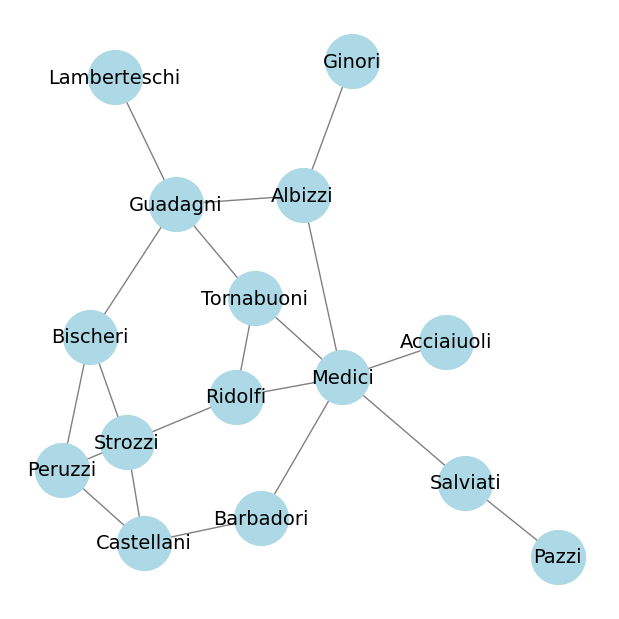

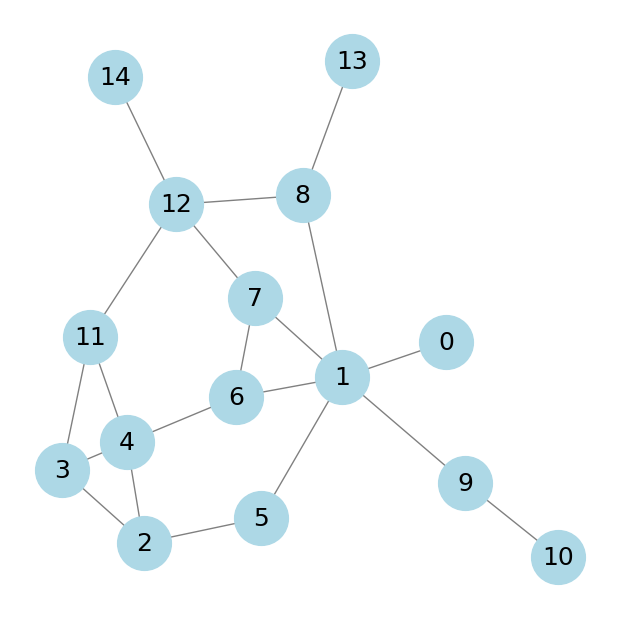

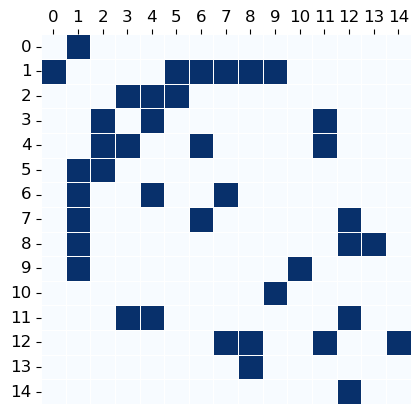

In [7]:
G = nx.florentine_families_graph()
pos = nx.spring_layout(G, seed=80)
plt.figure(figsize=(6,6))
nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=14)
#plt.title("Florentine Families network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
pos_relabel = {node_mapping[k]: v for k, v in pos.items()}
nx.draw(G,  pos=pos_relabel, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1500, font_size=18)
#plt.title("Florentine Families network with relabeled nodes")
plt.show()
#print("Map from original nodes to new nodes:")
#print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.gca().xaxis.tick_top() 
plt.gca().tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=12)
#plt.title("Sociomatrix for Florentine families")
plt.show() 

Metropolis-Hastings for Euclidean latent space models on networks
Number of chains: 2
MH samples of size 5000 with burn-in 50000 and thinning 15
Number of draws per chain: 125000
Initial sigma_q_Z: 1.0000
Initial sigma_q_alpha: 1.0000
Log-likelihood: Bernoulli
------------------------------------------------------------
Searching for MLE using gradient ascent
Best log-likelihood after 25 starts: -29.8192
------------------------------------------------------------
Log-prior:
sigma_prior_Z:  5.0
sigma_prior_alpha:  5.0
********************************
Chain 0
********************************


Sampling progress:  40%|████      | 50590/125000 [00:14<00:20, 3667.55 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 2.5540
Final sigma_q_alpha: 1.1442


Sampling progress: 100%|██████████| 125000/125000 [00:33<00:00, 3752.63 draws/s]


********************************
Chain 1
********************************


Sampling progress:  40%|████      | 50409/125000 [00:14<00:30, 2480.54 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 2.4911
Final sigma_q_alpha: 1.0831


Sampling progress: 100%|██████████| 125000/125000 [00:41<00:00, 3030.54 draws/s]


********************************
Trace convergence
********************************
Minimum R-hat: 1.0000
Maximum R-hat: 1.0280
Minimum ESS/n: 0.0146
Maximum ESS/n: 0.1889
********************************
Point information
********************************
----------------------------------------------------------------
Point        Log-likelihood        Log-prior    Log-posterior
----------------------------------------------------------------
Initial            -60.3347         -54.7291        -115.0638
ML                 -29.8192         -72.4278        -102.2470
CM                 -36.7910         -61.9848         -98.7758
MAP                -21.5592         -63.4095         -84.9687
----------------------------------------------------------------
********************************
Model information criteria
********************************
WAIC: 170.0638
DIC: 166.7049
BIC: 271.3913

Final acceptance rate Z: 0.3441
Final acceptance rate alpha: 0.3727
********************************
E

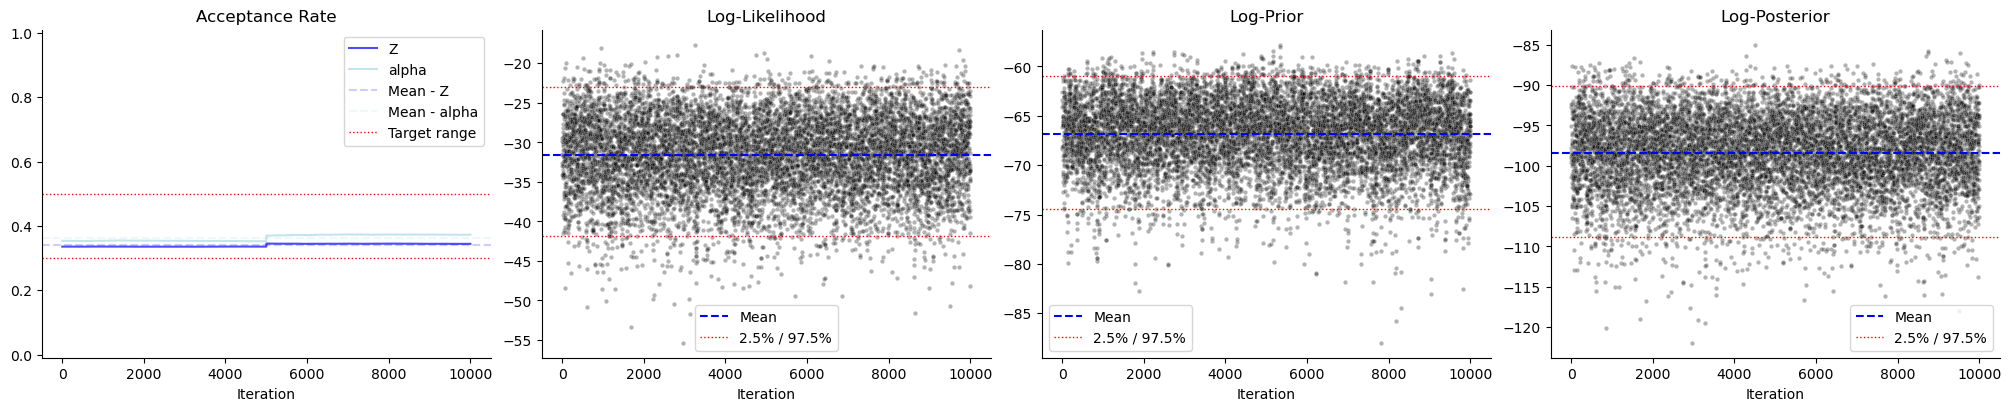

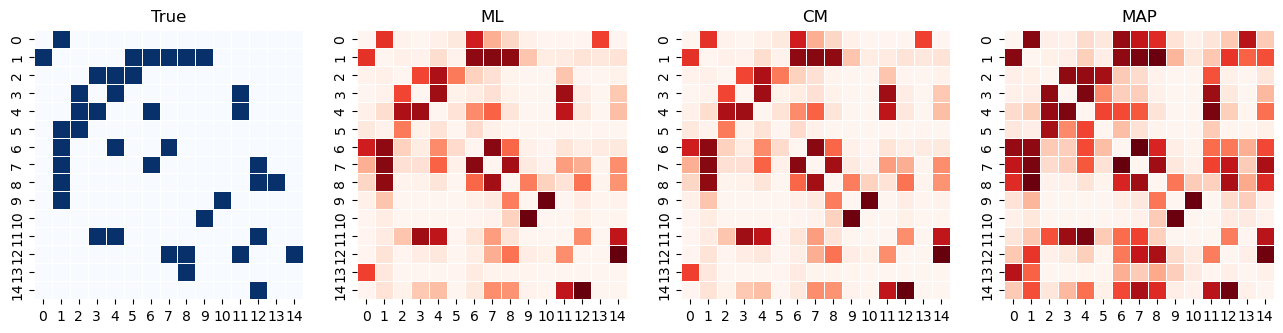

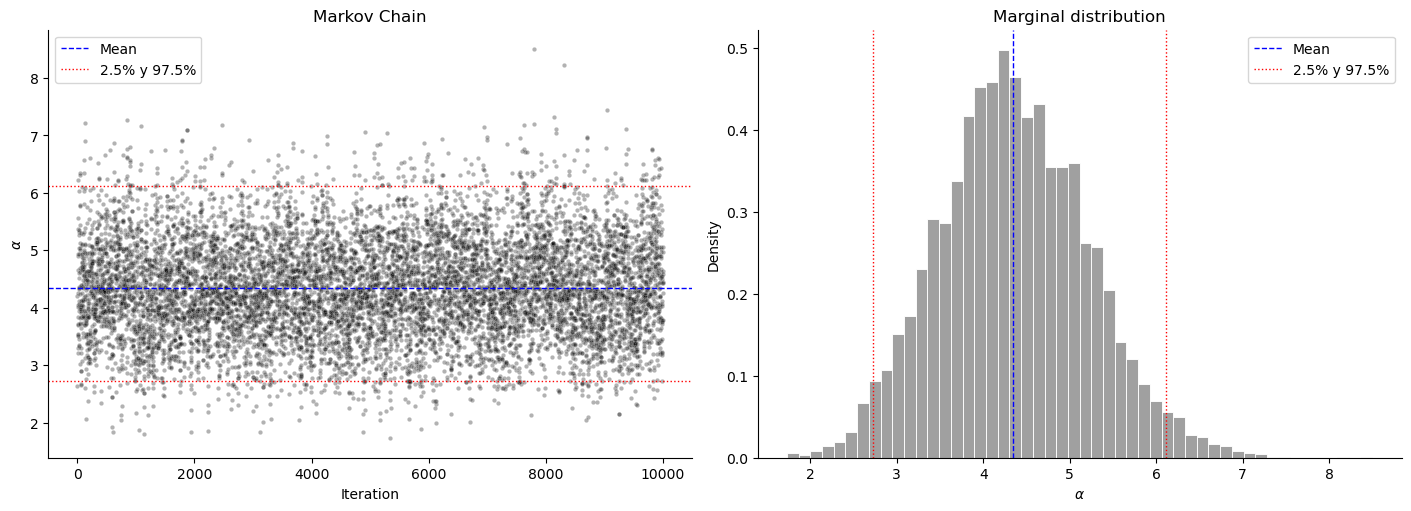

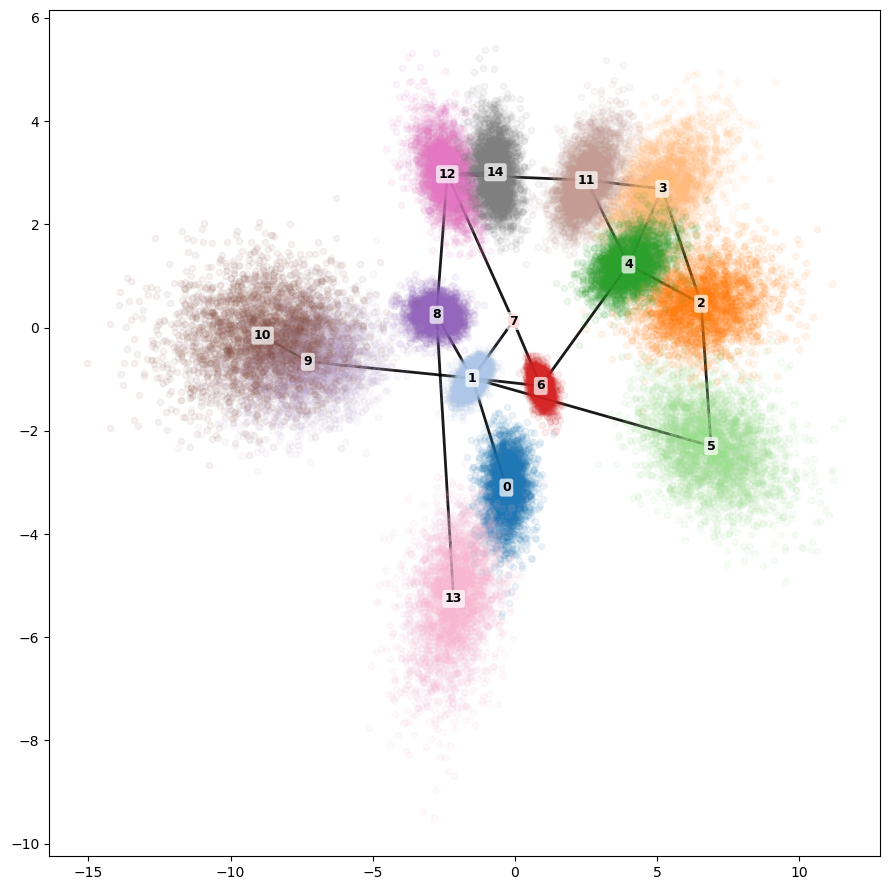

In [8]:
Theta_R2 = {
    'Z0': np.random.normal(0, 1, size=(n, 2)),
    'alpha0': np.float64(0.0),
    'sigma_prior_Z': 5.0,
    'sigma_prior_alpha': 5.0,
    'n_chains': 2,
    'n_samples': 5000,      
    'burn_in': 50000,       
    'thin': 15,              
    'sigma_q_Z': 1.0,       
    'sigma_q_alpha': 1.0    
}

# Estimation
resultsR2 = Estimation_LSMN(Y, Theta_R2, Model="Euclidean")

# Diagnostic analysis: Acceptance rate, Log probabilities traces, Adjacency matrices of point estimations, Traces of fixed parameters
plot_mcmc_diagnostics_panel(resultsR2)

#Visualizing latent space
plot_latent_space(resultsR2)

Metropolis-Hastings for Spherical latent space models on networks
Number of chains: 2
MH samples of size 5000 with burn-in 50000 and thinning 50
Number of draws per chain: 300000
Initial sigma_q_Z: 1.0000
Initial sigma_q_alpha: 0.5000
Initial sigma_q_beta: 0.5000
Log-likelihood: Bernoulli
------------------------------------------------------------
Searching for MLE using gradient ascent
Best log-likelihood after 25 starts: -35.4580
------------------------------------------------------------
Log-prior:
sigma_prior_alpha:  1.0
sigma_prior_beta:  1.0
********************************
Chain 0
********************************


Sampling progress:  17%|█▋        | 50865/300000 [00:14<00:58, 4272.92 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 1.2648
Final sigma_q_alpha: 0.6880
Final sigma_q_beta: 1.6709


Sampling progress: 100%|██████████| 300000/300000 [01:12<00:00, 4142.00 draws/s]


********************************
Chain 1
********************************


Sampling progress:  17%|█▋        | 51223/300000 [00:12<00:57, 4325.67 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 1.1912
Final sigma_q_alpha: 0.8526
Final sigma_q_beta: 1.7213


Sampling progress: 100%|██████████| 300000/300000 [01:10<00:00, 4273.19 draws/s]


********************************
Trace convergence
********************************
Minimum R-hat: 0.9999
Maximum R-hat: 1.0038
Minimum ESS/n: 0.0459
Maximum ESS/n: 0.9439
********************************
Point information
********************************
----------------------------------------------------------------
Point        Log-likelihood        Log-prior    Log-posterior
----------------------------------------------------------------
Initial           -156.6460         -46.5490        -203.1950
ML                 -35.4580         -78.6220        -114.0800
CM                 -45.6956         -58.5026        -104.1982
MAP                -44.2759         -54.9657         -99.2416
----------------------------------------------------------------
********************************
Model information criteria
********************************
WAIC: 384.4925
DIC: 260.8819
BIC: 253.2617

Final acceptance rate Z: 0.3176
Final acceptance rate alpha: 0.4199
Final acceptance rate beta: 0.3209

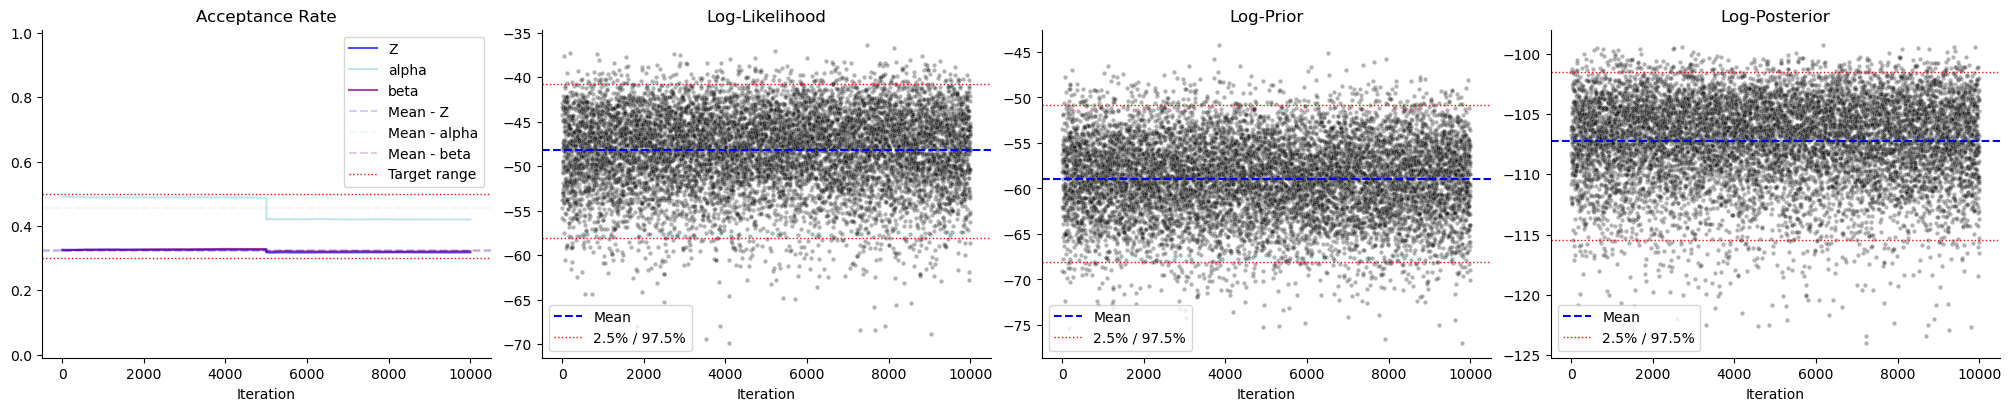

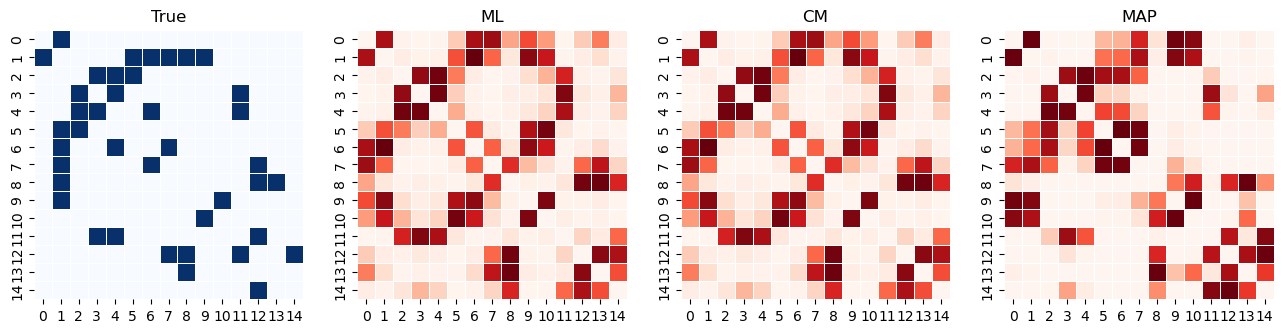

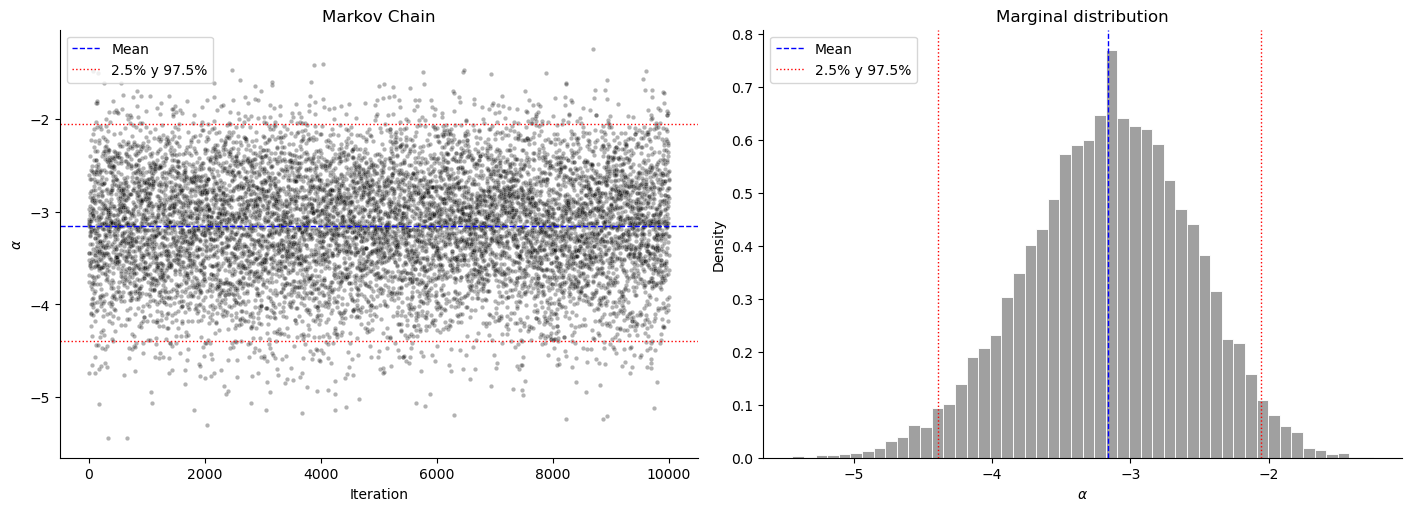

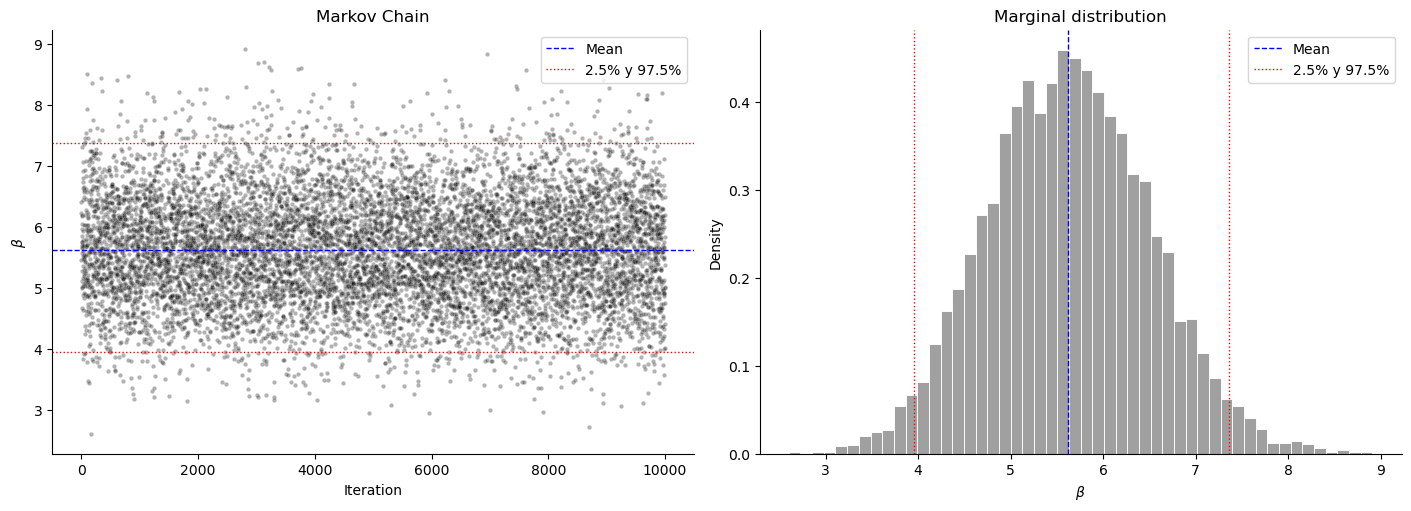

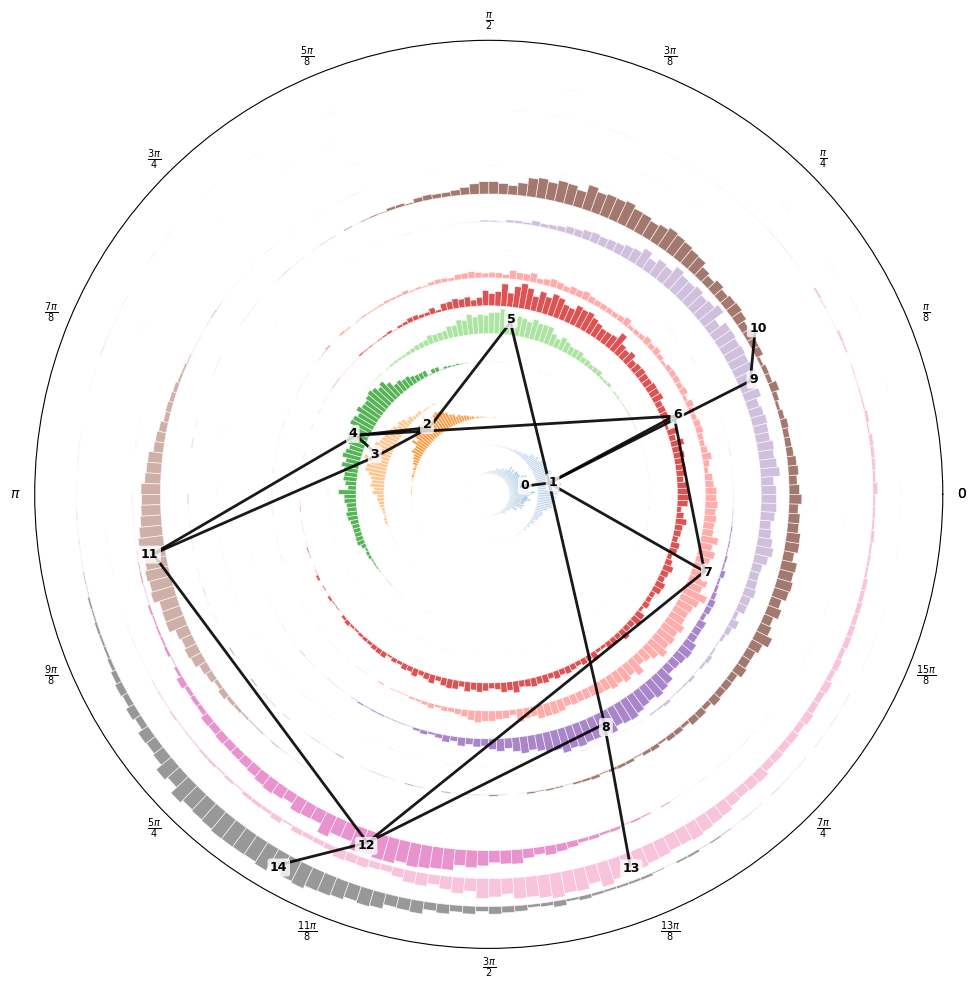

In [9]:
# Configuration
Theta_S1 = {
    'Z0': random_VMF(np.array([0,1]), 0, n),
    'alpha0': np.float64(0.0),
    'beta0': np.float64(5.0),
    'rho': -0.5,
    'mu_alpha_beta': np.array([0.0, 10.0]),
    'sigma_prior_alpha': 1.0,
    'sigma_prior_beta': 1.0,
    'n_chains': 2,
    'n_samples': 5000,      
    'burn_in': 50000,       
    'thin': 50,                
    'sigma_q_Z': 1.0,       
    'sigma_q_alpha': 0.5,    
    'sigma_q_beta': 0.5      
}

# Estimation
resultsS1 = Estimation_LSMN(Y, Theta_S1, Model="Spherical")

# Diagnostic analysis: Acceptance rate, Log probabilities traces, Adjacency matrices of point estimations, Traces of fixed parameters
plot_mcmc_diagnostics_panel(resultsS1)

#Visualizing latent space
plot_latent_space(resultsS1)

# Posterior predictive checking
#posterior_predictive_check(resultsS1)

# Prior predictive checking
#prior_predictive_check(resultsS1)

# Prediction evaluation
#metricsS1 = prediction_evaluation(resultsS1)

# Save results
#handle_results(resultsS1, filepath='resultsS1.pkl', mode='save')

# Conclave: Model $\mathbb{R}^2$

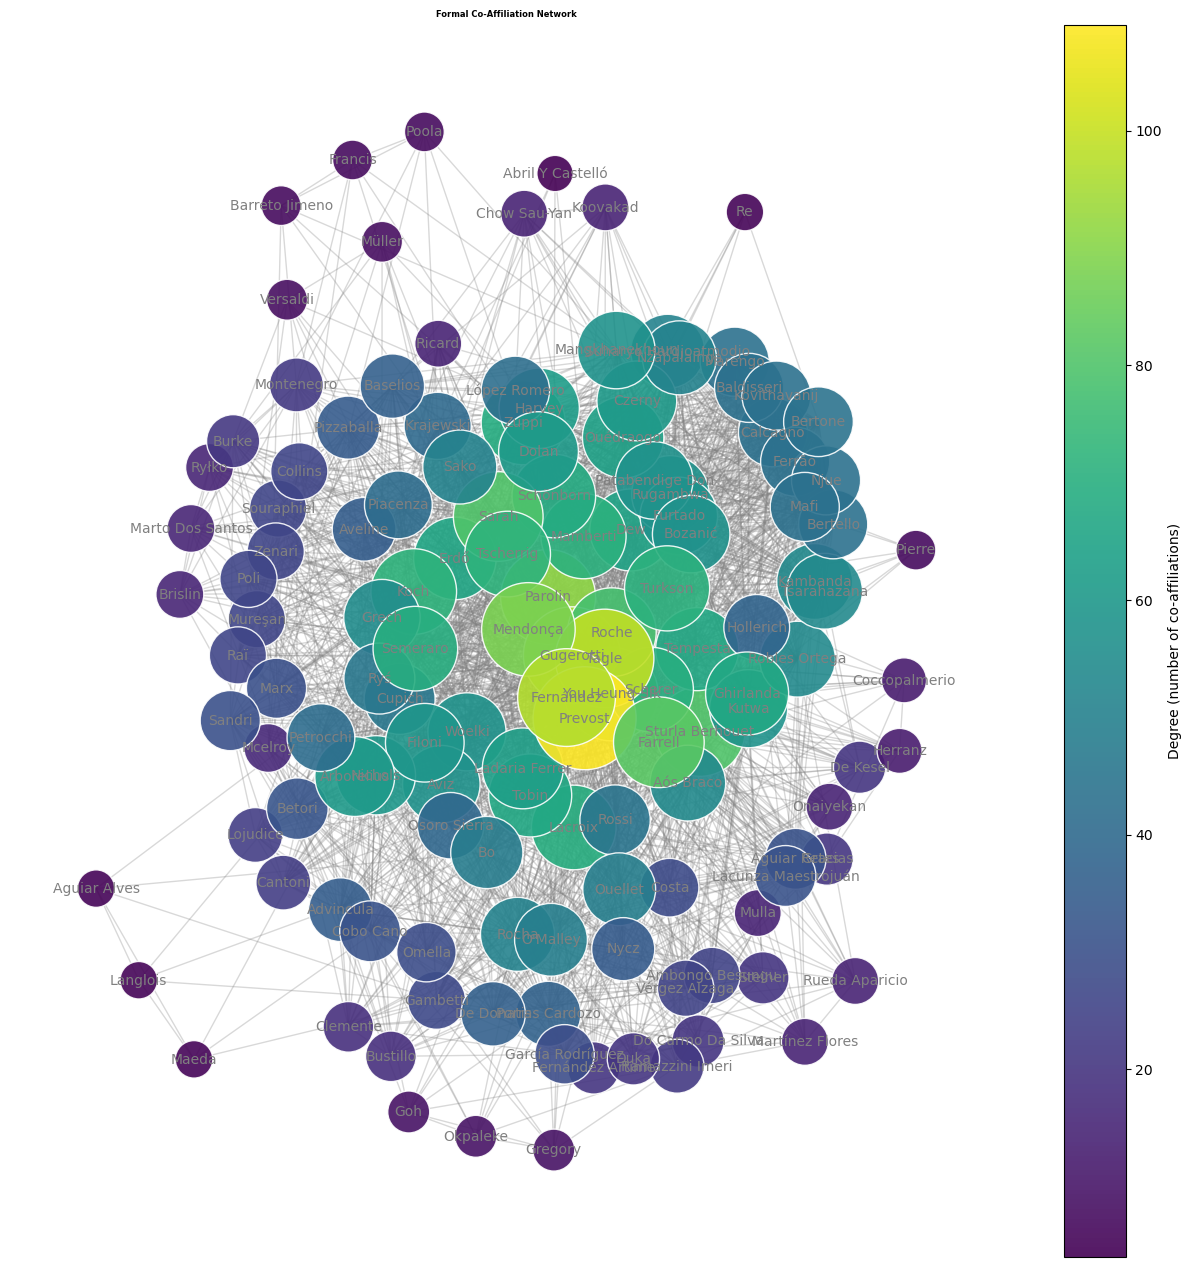

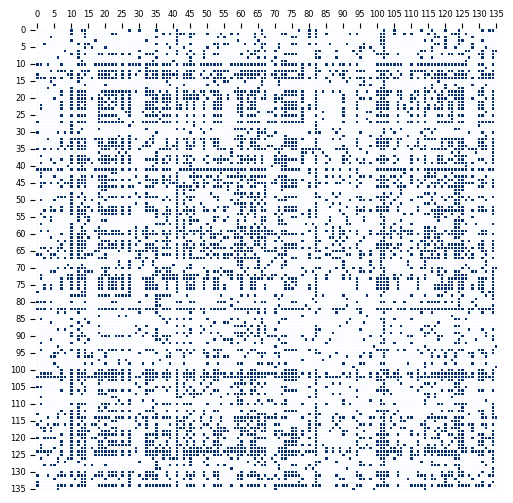

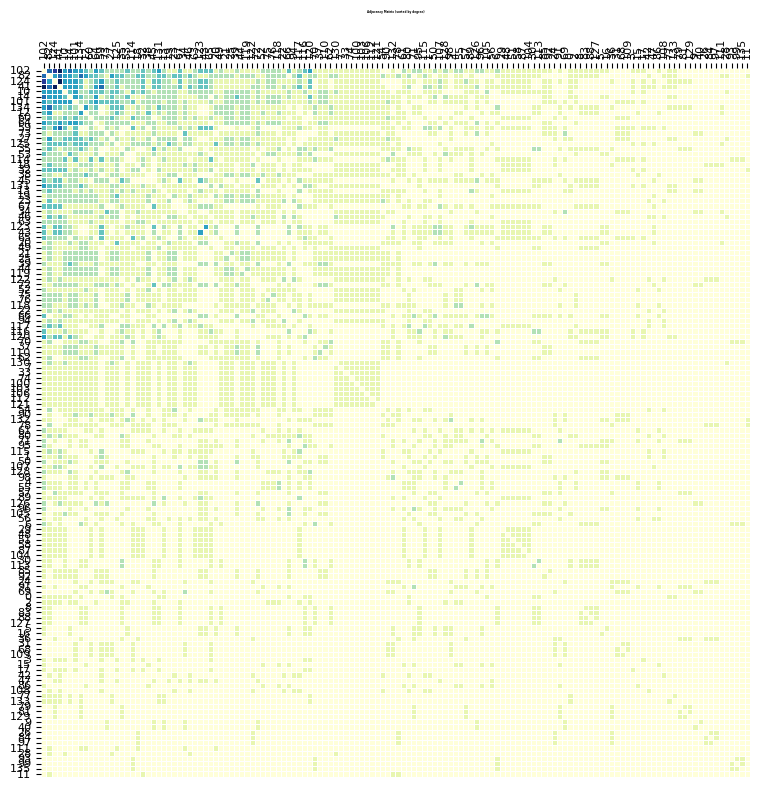

In [10]:
df1=pd.read_excel('Conclave/data/formal.xlsx')
all_cardinals = set(df1['Person'].unique())

G_formal = nx.Graph()
G_formal.add_nodes_from(all_cardinals)
from collections import defaultdict
weights = defaultdict(int)

# Process Group co-affiliations from df1
groups = df1.groupby('Membership')['Person'].apply(list).to_dict()
for group, cardinals in groups.items():
    if len(cardinals) > 1:  # Only consider groups with at least 2 cardinals
        for i in range(len(cardinals)):
            for j in range(i+1, len(cardinals)):
                cardinal_pair = tuple(sorted([cardinals[i], cardinals[j]]))
                weights[cardinal_pair] += 1
for (cardinal1, cardinal2), weight in weights.items():
    G_formal.add_edge(cardinal1, cardinal2, weight=weight)


G = G_formal.copy()
pos = nx.kamada_kawai_layout(G, scale=0.10)
degrees = dict(G.degree())
max_deg = max(degrees.values())
node_sizes = [500 + 5000 * (deg / max_deg) for deg in degrees.values()]
node_colors = [deg for deg in degrees.values()]
plt.figure(figsize=(16,16))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=1, edge_color='gray')
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap='viridis',
    alpha=0.9,
    linewidths=1,
    edgecolors='white'
)
nx.draw_networkx_labels(G, pos, font_size=10,font_color='gray')
plt.colorbar(nodes, label='Degree (number of co-affiliations)')
plt.axis('off')
plt.title("Formal Co-Affiliation Network", fontsize=6, weight='bold')
plt.show()


node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
pos_relabel = {node_mapping[k]: v for k, v in pos.items()}


Y = nx.to_numpy_array(G, dtype=float) > 0

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.gca().xaxis.tick_top() 
plt.gca().tick_params(top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=6)
plt.show() 


import seaborn as sns
import matplotlib.pyplot as plt

# Ordenar por grado (u otra medida)
degree_order = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)
Y = nx.to_numpy_array(G, nodelist=degree_order, dtype=float)

plt.figure(figsize=(8,8))
sns.heatmap(Y, cmap="YlGnBu", cbar=False, square=True, linewidths=0.5)
plt.xticks(np.arange(len(degree_order)) + 0.5, degree_order, rotation=90, fontsize=8)
plt.yticks(np.arange(len(degree_order)) + 0.5, degree_order, rotation=0, fontsize=8)
plt.gca().xaxis.tick_top()
plt.title("Adjacency Matrix (sorted by degree)", pad=40, fontsize=2, weight='bold')
plt.tight_layout()
plt.show()

Metropolis-Hastings for Euclidean latent space models on networks
Number of chains: 2
MH samples of size 500 with burn-in 100 and thinning 1
Number of draws per chain: 600
Initial sigma_q_Z: 1.0000
Initial sigma_q_alpha: 1.0000
Log-likelihood: Bernoulli
------------------------------------------------------------
Searching for MLE using gradient ascent
Best log-likelihood after 25 starts: -6906.1114
------------------------------------------------------------
Log-prior:
sigma_prior_Z:  5.0
sigma_prior_alpha:  5.0
********************************
Chain 0
********************************


Sampling progress:  17%|█▋        | 102/600 [00:24<01:32,  5.38 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 0.8956
Final sigma_q_alpha: 0.6149


Sampling progress: 100%|██████████| 600/600 [01:42<00:00,  5.83 draws/s]


********************************
Chain 1
********************************


Sampling progress:  17%|█▋        | 102/600 [00:13<01:05,  7.55 draws/s]

--------------------------------
Tuning complete
--------------------------------
Final sigma_q_Z: 0.8433
Final sigma_q_alpha: 0.6465


Sampling progress: 100%|██████████| 600/600 [01:20<00:00,  7.42 draws/s]


********************************
Trace convergence
********************************
Minimum R-hat: 0.9994
Maximum R-hat: 8.0152
Minimum ESS/n: 0.0033
Maximum ESS/n: 0.5477
********************************
Point information
********************************
----------------------------------------------------------------
Point        Log-likelihood        Log-prior    Log-posterior
----------------------------------------------------------------
Initial          -7829.5927        -475.8118       -8305.4045
ML               -6906.1114        -578.5742       -7484.6857
CM              -14307.1175       -1142.4676      -15449.5850
MAP               2741.6837       -1913.4948         828.1890
----------------------------------------------------------------
********************************
Model information criteria
********************************
WAIC: 131138.1431
DIC: 98106.5680
BIC: 100750.2134

Final acceptance rate Z: 0.3383
Final acceptance rate alpha: 0.1767
**************************

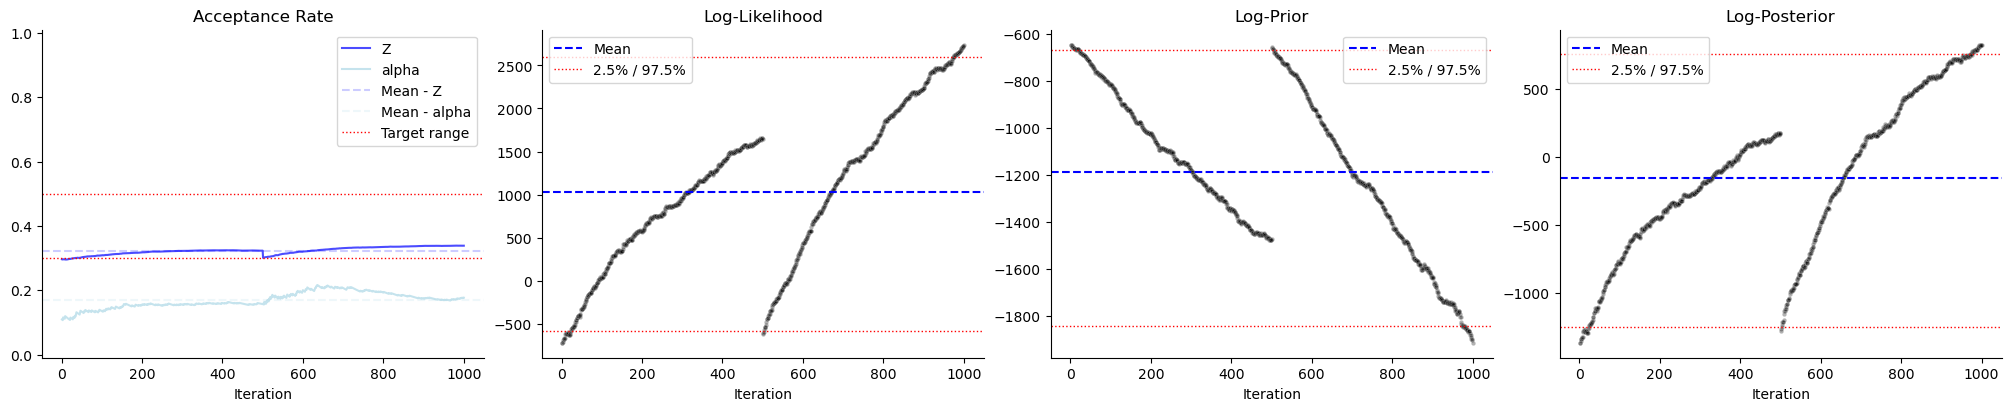

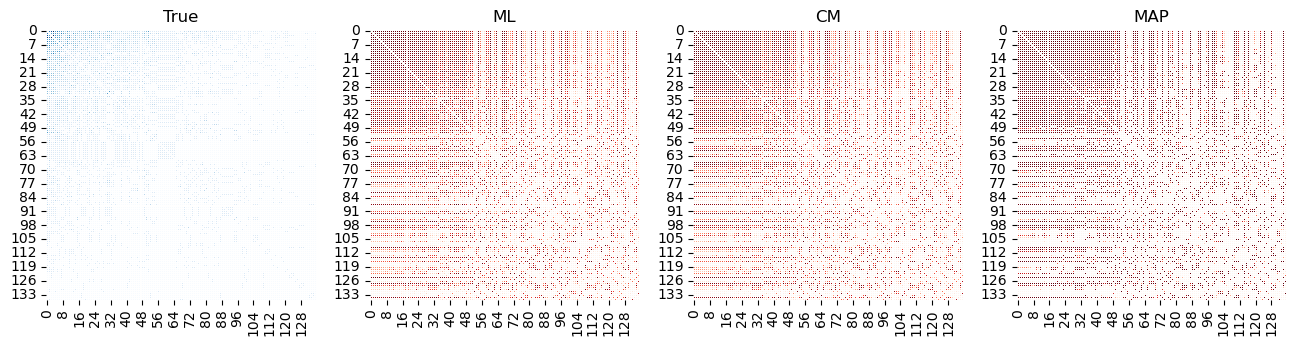

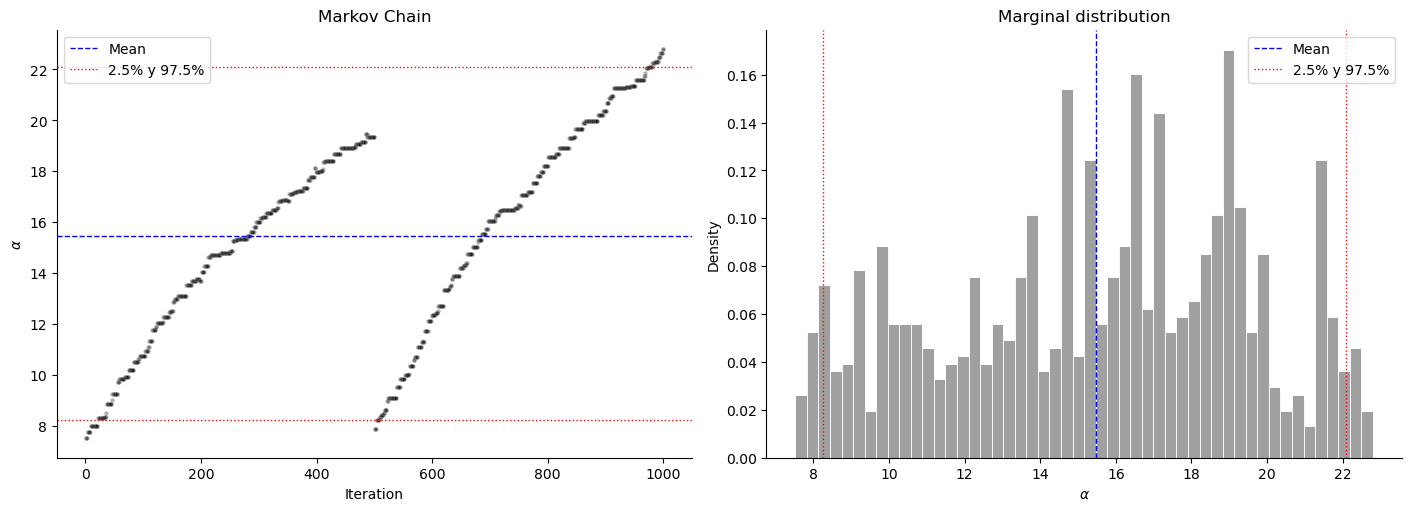

In [12]:
Theta_R2 = {
    'Z0': np.random.normal(0, 1, size=(n, 2)),
    'alpha0': np.float64(0.0),
    'sigma_prior_Z': 5.0,
    'sigma_prior_alpha': 5.0,
    'n_chains': 2,
    'n_samples': 500,      
    'burn_in': 100,       
    'thin': 1,              
    'sigma_q_Z': 1.0,       
    'sigma_q_alpha': 1.0    
}

# Estimation
resultsR2_Conclave = Estimation_LSMN(Y, Theta_R2, Model="Euclidean")

# Diagnostic analysis: Acceptance rate, Log probabilities traces, Adjacency matrices of point estimations, Traces of fixed parameters
plot_mcmc_diagnostics_panel(resultsR2_Conclave)